# Bayesian Network and Experimental Design

# Libraries

In [1]:
!pip install pybbn

In [1]:
import pybbn
import pandas as pd
pd.set_option('display.max_rows', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import networkx as nx 
import matplotlib.pyplot as plt
%matplotlib inline
import random
import sys

from utils_sys import Printer

from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.sampling.sampling import LogicSampler

from scipy.stats import binom
import numpy as np
np.seterr(invalid='ignore')
import plotly
import plotly.io as pio
import chart_studio
import chart_studio.plotly as cspy
import chart_studio.tools as tls
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from urllib.request import urlopen
import json

import seaborn as sns 

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

username = 'vishalgattani' # your username\n",
api_key = 'WSy2EFPTbxYYm3Rmcx53' # your api key - go to profile > settings > regenerate key\n",
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)


# Functions

In [8]:
def getBinomProb(total_exp_runs,p):
    return list(binom.pmf(list(range(total_exp_runs + 1)),total_exp_runs, p))

def evidence(join_tree,ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
def resetEvidence(join_tree):
    join_tree.unobserve_all()
    
def print_probs(join_tree):
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node.to_dict())
        print("Values:")
        print(potential)
        print('----------------')
        
    print("="*90)
        
def print_probs_node(join_tree,id):
    for node in join_tree.get_bbn_nodes():
        if (node.to_dict()['variable']['id']==id):
            potential = join_tree.get_bbn_potential(node)
            df = potential_to_df(join_tree.get_bbn_potential(node))
#             display(df)
            return df
            
def potential_to_df(p):
    data = []
    for pe in p.entries:
        try:
            v = pe.entries.values()[0]
        except:
            v = list(pe.entries.values())[0]
        p = pe.value
        t = (v, p)
        data.append(t)
    return pd.DataFrame(data, columns=['val', 'p'])

def potentials_to_dfs(join_tree):
    data = []
    for node in join_tree.get_bbn_nodes():
        name = node.variable.name
        df = potential_to_df(join_tree.get_bbn_potential(node))
        display(df)
        t = (name, df)
        data.append(t)
    return data

def drawBBN(bbn):
    n, d = bbn.to_nx_graph()
    pos = nx.spring_layout(n)
    nx.draw_spring(n, with_labels=True,labels=d)
    ax = plt.gca()
    
    plt.show()

def plotROC(p,r,fpr_tree, tpr_tree,fpr_lr, tpr_lr,fpr_lrl2, tpr_lrl2,fpr_nb, tpr_nb):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr_tree, y=tpr_tree, mode="markers+lines",name='DT'))
    fig.add_trace(go.Scatter(x=fpr_lr, y=tpr_lr, mode="markers+lines",name='LR'))
    fig.add_trace(go.Scatter(x=fpr_lrl2, y=tpr_lrl2, mode="markers+lines",name='LR(L2)'))
#     fig.add_trace(go.Scatter(x=fpr_nb, y=tpr_nb, mode="markers+lines",name='NB'))
    fig.update_layout(hovermode="x",title='Receiver Operating Characteristic '+"p="+str(p)+",r="+str(r))
    fig.update_xaxes(title_text='TPR')
    fig.update_yaxes(title_text='FPR')
    fig.show()
    
def getFPTN(join_tree):
    evidence(join_tree,'ev1', 'Algorithm works correctly', 'False', 1.0)
    df = print_probs_top_node(join_tree)
    resetEvidence(join_tree)
    dffp = df[df['val']=='Correct']['p']
    dftn = df[df['val']=='Incorrect']['p']
    return dffp,dftn
    
def getFNTP(join_tree):
    evidence(join_tree,'ev1', 'Algorithm works correctly', 'True', 1.0)
    df = print_probs_top_node(join_tree)
    resetEvidence(join_tree)
    dffn = df[df['val']=='Incorrect']['p']
    dftp = df[df['val']=='Correct']['p']
    return dffn,dftp

# Bayesian Network using `pybbn`

In [19]:
threshold_num_runs = 2 # rule
total_exp_runs = 3

p = 0.8
r = 0.01

exp_T = getBinomProb(total_exp_runs,p)
exp_F = getBinomProb(total_exp_runs,r)


exp_dict = {"True":exp_T,"False":exp_F}
exp_cpt = pd.DataFrame(exp_dict)

test_keys = []
test_values = []

for i in range(total_exp_runs+1):
    test_keys.append(str(i))
    if i >= threshold_num_runs:
        test_values.append([1,0])
    else:
        test_values.append([0,1])

test_results_dict = dict(zip(test_keys, test_values))
test_results_cpt = pd.DataFrame(test_results_dict) 
test_results_cpt["States"] = ['Correct','Incorrect']
test_results_cpt.set_index("States",inplace=True)

display(test_results_cpt)


# Create nodes by manually typing in probabilities
test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

bbn = Bbn() \
    .add_node(algo) \
    .add_node(exp1) \
    .add_node(test_results) \
    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))
join_tree = InferenceController.apply(bbn)

,0,1,2,3
States,,,,
Correct,0,0,1,1
Incorrect,1,1,0,0


# Plotting the BBN

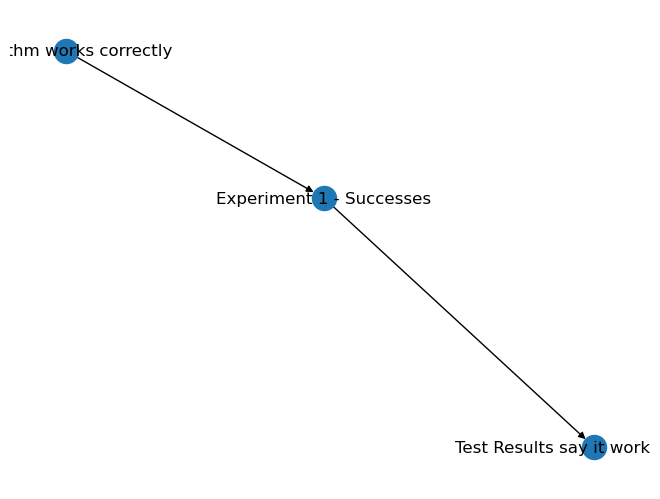

In [242]:
drawBBN(bbn)  

# Printing values of nodes within BBN without setting evidence

In [20]:
print_probs(join_tree)

Node: {'probs': [0.007999999999999995, 0.0960000000000001, 0.3840000000000001, 0.5120000000000001, 0.970299, 0.02940300000000001, 0.000297, 1.0000000000000002e-06], 'variable': {'id': 1, 'name': 'Experiment 1 - Successes', 'values': Index(['0', '1', '2', '3'], dtype='object')}}
Values:
1=0|0.48915
1=1|0.06270
1=2|0.19215
1=3|0.25600
----------------
Node: {'probs': [0, 1, 0, 1, 1, 0, 1, 0], 'variable': {'id': 0, 'name': 'Test Results say it works properly', 'values': ['Correct', 'Incorrect']}}
Values:
0=Correct|0.44815
0=Incorrect|0.55185
----------------
Node: {'probs': [0.5, 0.5], 'variable': {'id': 2, 'name': 'Algorithm works correctly', 'values': ['True', 'False']}}
Values:
2=True|0.50000
2=False|0.50000
----------------


# Setting evidence in BBN

In [23]:
for i in range(4):
    evidence(join_tree,'ev1', 'Experiment 1 - Successes', str(i), 1.0)
    # print_probs(join_tree)
    df = print_probs_node(join_tree,1)
    # display(df)
    df = print_probs_node(join_tree,2)
    # display(df)
    resetEvidence(join_tree)

In [22]:
evidence(join_tree,'ev1', 'Algorithm works correctly', 'True', 1.0)
print_probs(join_tree)
df = print_probs_node(join_tree,0)
display(df)
resetEvidence(join_tree)

Node: {'probs': [0.007999999999999995, 0.0960000000000001, 0.3840000000000001, 0.5120000000000001, 0.970299, 0.02940300000000001, 0.000297, 1.0000000000000002e-06], 'variable': {'id': 1, 'name': 'Experiment 1 - Successes', 'values': Index(['0', '1', '2', '3'], dtype='object')}}
Values:
1=0|0.00800
1=1|0.09600
1=2|0.38400
1=3|0.51200
----------------
Node: {'probs': [0, 1, 0, 1, 1, 0, 1, 0], 'variable': {'id': 0, 'name': 'Test Results say it works properly', 'values': ['Correct', 'Incorrect']}}
Values:
0=Correct|0.89600
0=Incorrect|0.10400
----------------
Node: {'probs': [0.5, 0.5], 'variable': {'id': 2, 'name': 'Algorithm works correctly', 'values': ['True', 'False']}}
Values:
2=True|1.00000
2=False|0.00000
----------------


,val,p
0,Correct,0.896
1,Incorrect,0.104


# Generating graphs

- Setting `r` as a fraction of `p`.
- Changing `threshold_num_runs` from `1...n` where `n` is experiment runs.
- Gathering false positives and true positives from the above methods for a certain `p,r` combination.

# False Negatives and False Positives

- False negative (FN): The probability of node “test results say it works properly” is `incorrect` given the node “Algorithm works correctly” is `True`. 

- False Positive (FP): The probability of node “test results say it works properly” is `correct` given the node “Algorithm works correctly” is `False`. 

In [29]:
def getFPTN(join_tree):
    # evidence(join_tree,'ev1', 'Algorithm works correctly', 'False', 1.0)
    df = print_probs_node(join_tree,0)
    resetEvidence(join_tree)
    dffp = df[df['val']=='Correct']['p']
    dftn = df[df['val']=='Incorrect']['p']
    return dffp,dftn
    
def getFNTP(join_tree):
    # evidence(join_tree,'ev1', 'Algorithm works correctly', 'True', 1.0)
    df = print_probs_node(join_tree,0)
    resetEvidence(join_tree)
    dffn = df[df['val']=='Incorrect']['p']
    dftp = df[df['val']=='Correct']['p']
    return dffn,dftp

In [31]:
threshold_num_runs = 2 # rule
min_exp_runs = 3
max_exp_runs = 15

total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))

p_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
p_list = [0.5,0.9]

p_list = [round(x, 2) for x in p_list]

proportionality_factor = list(np.linspace(0.1,1,10))
proportionality_factor = [round(x, 2) for x in proportionality_factor]
proportionality_factor = [0.25,0.5,0.75]

row = []

for total_exp_runs in total_exp_runs_list:
    for threshold_num_runs in range(1,total_exp_runs+1):
        if total_exp_runs%3!=0:
                continue
        else: pass
        for k in proportionality_factor:
            for p in p_list:
                r = k*p
                r = round(r,3)
#                 print("p(successful run|algo = T):",p)
#                 print("p(successful run|algo = F):",r," r = ",k,"*","p")
                exp_T = getBinomProb(total_exp_runs,p)
                exp_F = getBinomProb(total_exp_runs,r)
                exp_dict = {"True":exp_T,"False":exp_F}
                exp_cpt = pd.DataFrame(exp_dict)
                test_keys = []
                test_values = []

                for i in range(total_exp_runs+1):
                    test_keys.append(str(i))
                    if i >= threshold_num_runs:
                        test_values.append([1,0])
                    else:
                        test_values.append([0,1])

                test_results_dict = dict(zip(test_keys, test_values))
                test_results_cpt = pd.DataFrame(test_results_dict) 
                test_results_cpt["States"] = ['Correct','Incorrect']
                test_results_cpt.set_index("States",inplace=True)


                # Create nodes by manually typing in probabilities
                test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                bbn = Bbn() \
                    .add_node(algo) \
                    .add_node(exp1) \
                    .add_node(test_results) \
                    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                join_tree = InferenceController.apply(bbn)
                # evidence(join_tree,'ev1', 'Experiment 1 - Successes', str(threshold_num_runs), 1.0)
                # # print_probs(join_tree)
                # df = print_probs_node(join_tree,2)
                # display(df)

                dffp,dftn = getFPTN(join_tree)
                dffn,dftp = getFNTP(join_tree)
                
#                 print("FP : P(Test=T|Algo=F)=",dffp.tolist())
#                 print("TN : P(Test=F|Algo=F)=",dftn.tolist())
#                 print("FN : P(Test=F|Algo=T)=",dffn.tolist())
#                 print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                fp = dffp.tolist()[0]
                tn = dftn.tolist()[0]
                fn = dffn.tolist()[0]
                tp = dftp.tolist()[0]
                
                

                data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                row.append(data)
                
                
                resetEvidence(join_tree)
#                 print("+"*80)
                
    checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
#     display(checkdf)
    
df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
display(df)    


,n_exp,threshold_exp,p,r,fp,tn,fn,tp
0,3,1,0.5,0.125,0.602539,3.974609e-01,3.974609e-01,0.602539
1,3,1,0.9,0.225,0.766758,2.332422e-01,2.332422e-01,0.766758
2,3,1,0.5,0.250,0.726563,2.734375e-01,2.734375e-01,0.726563
3,3,1,0.9,0.450,0.916312,8.368750e-02,8.368750e-02,0.916312
4,3,1,0.5,0.375,0.815430,1.845703e-01,1.845703e-01,0.815430
5,3,1,0.9,0.675,0.982336,1.766406e-02,1.766406e-02,0.982336
6,3,2,0.5,0.125,0.271484,7.285156e-01,7.285156e-01,0.271484
7,3,2,0.9,0.225,0.550547,4.494531e-01,4.494531e-01,0.550547
8,3,2,0.5,0.250,0.328125,6.718750e-01,6.718750e-01,0.328125
9,3,2,0.9,0.450,0.698625,3.013750e-01,3.013750e-01,0.698625


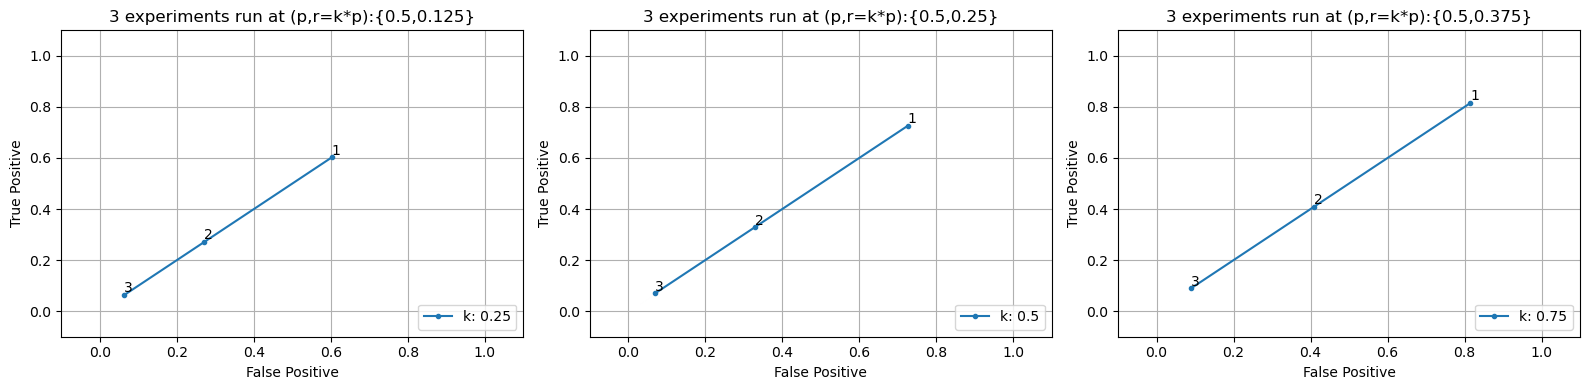

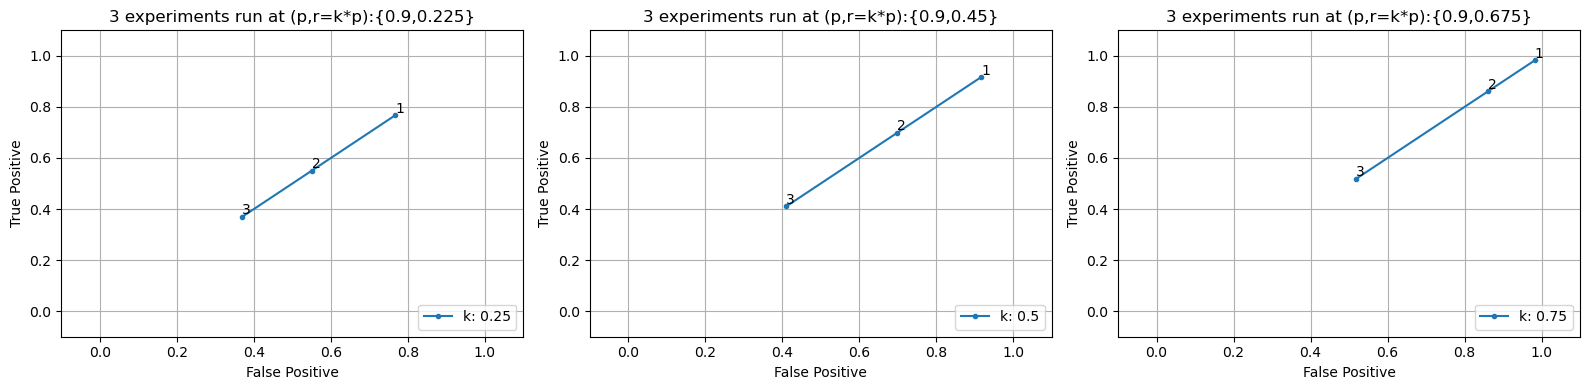

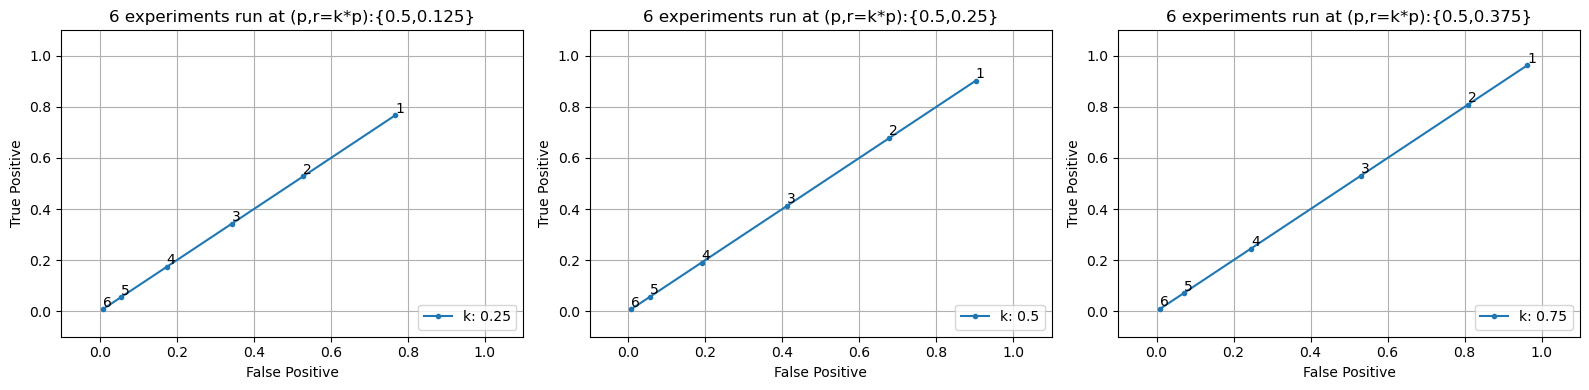

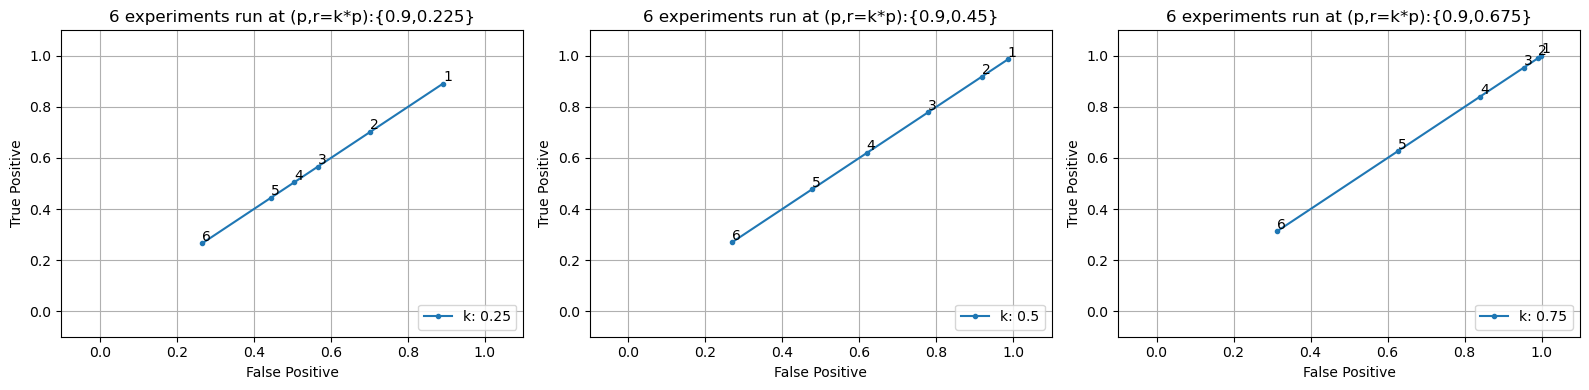

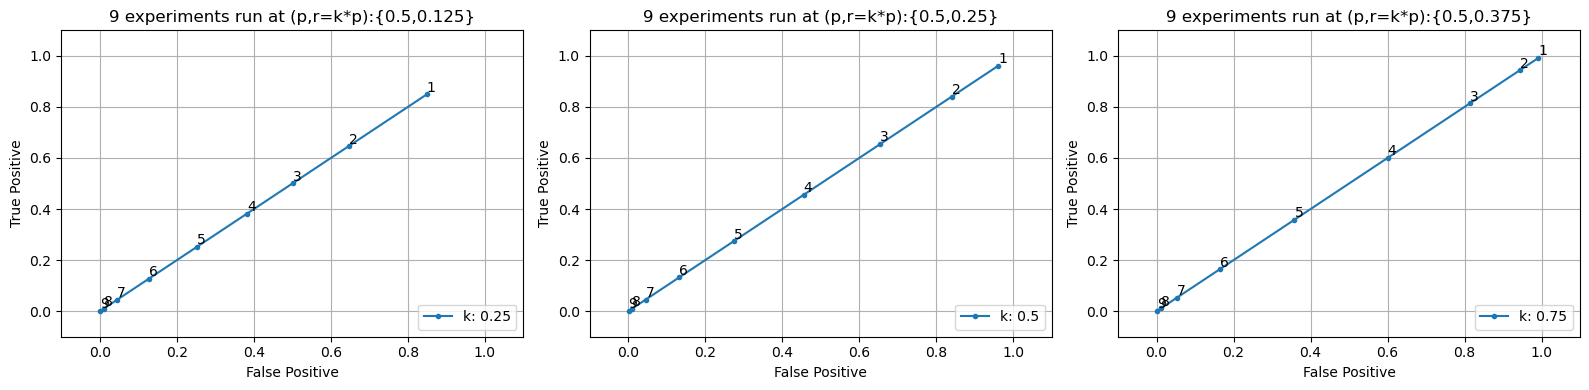

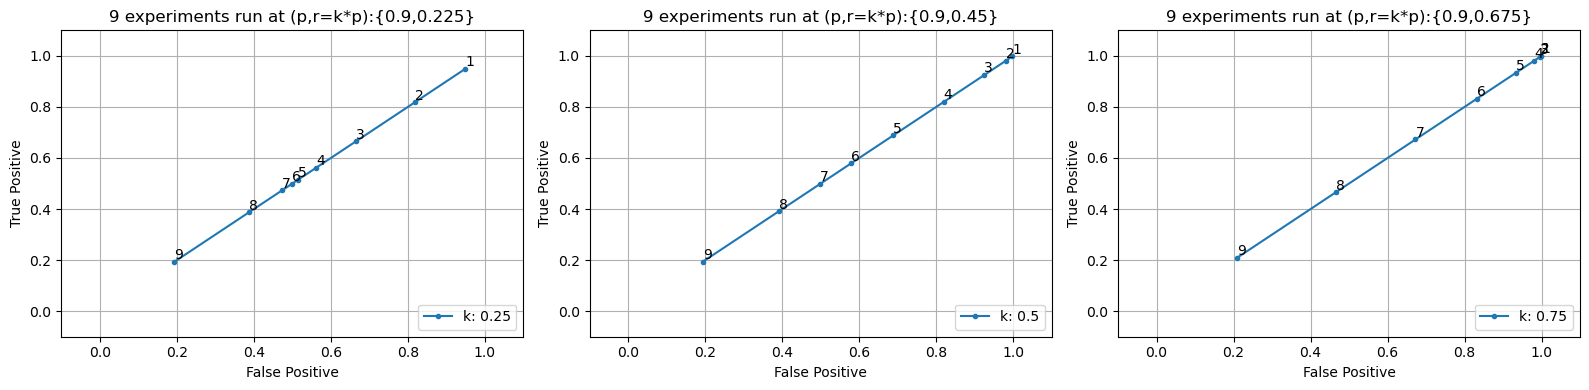

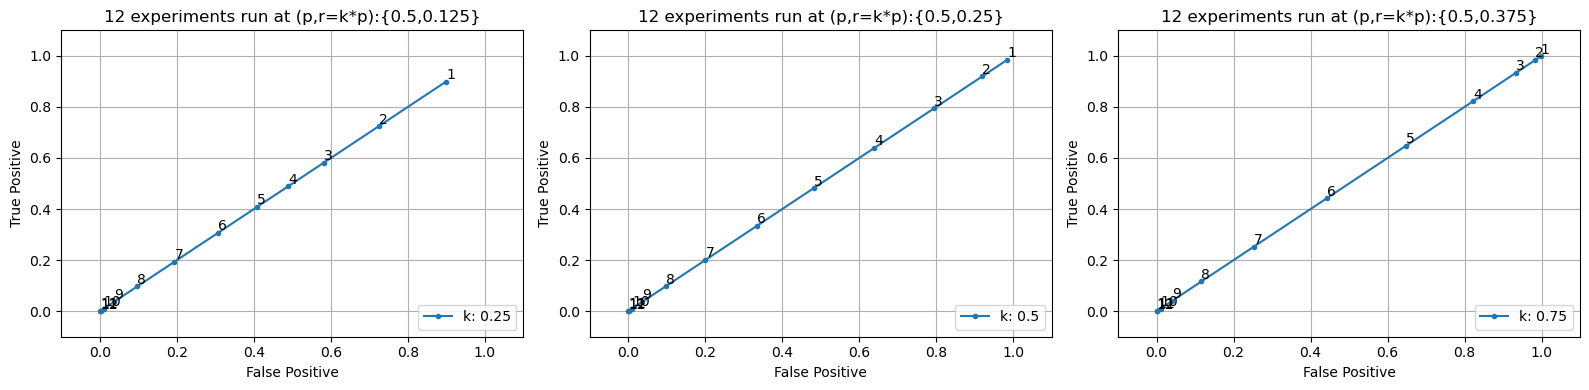

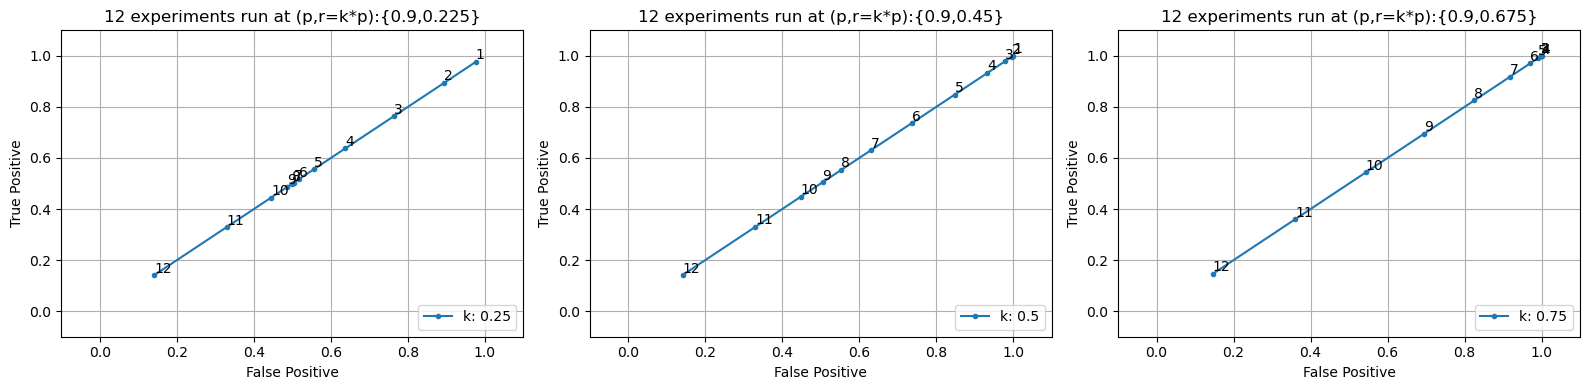

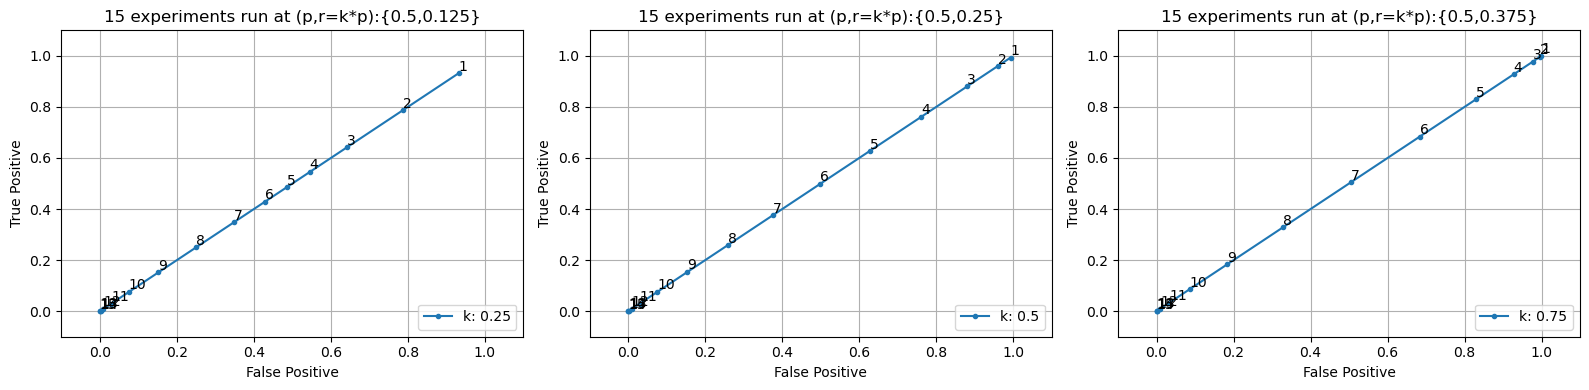

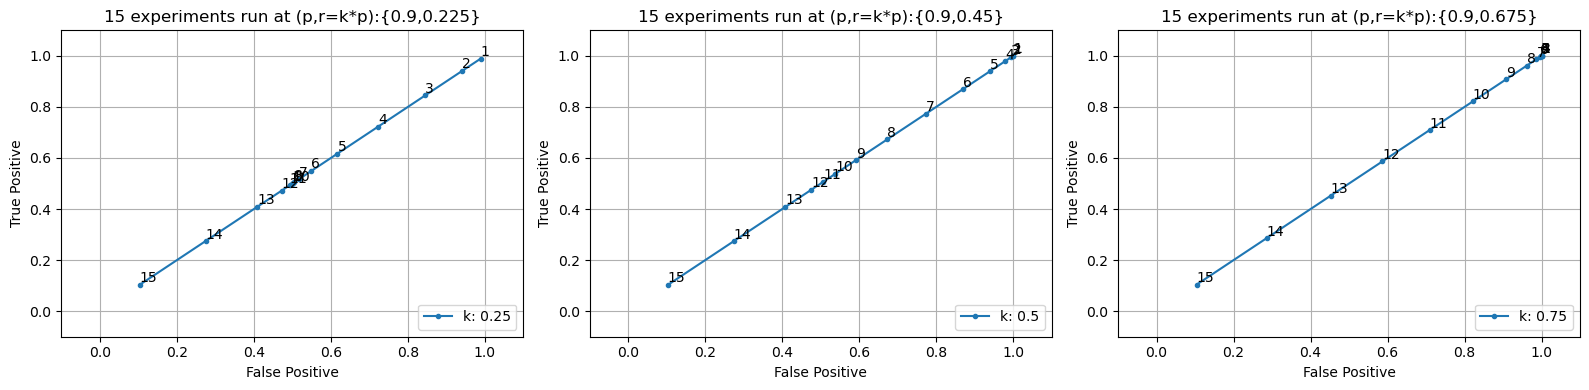

<Figure size 1600x400 with 0 Axes>

In [32]:
dfs = df.groupby(['n_exp','p'])
# fig = go.Figure()
best_dfs = []

subplots_df = []
for i in dfs:
    i[1]['groups'] = np.floor_divide(i[1].index, len(p_list)).astype(str)
#     print(i[1]['groups'].values.tolist())
    i[1]['k'] = i[1]['groups'].apply(lambda d: proportionality_factor[int(d)%len(proportionality_factor)])
    # display(i[1])
    # i[1]['threshold_exp'] = i[1]['threshold_exp'].astype('string')
    # display(i[1])
    
    klist = i[1]['k'].unique().tolist()
    klist = "-".join([str(e) for e in klist])
    
    
    # fpr = i[1].fp.to_numpy()
    # tpr = i[1].tp.to_numpy()
    # distances = [np.sqrt((1 - tpr[i])**2 + fpr[i]**2) for i in range(len(fpr))]
    # i[1]["distances"] = distances
    
    # plt.plot(i[1].fp,i[1].tp,marker=".")
    # plt.legend(i[1].k.unique().tolist()  ,loc='lower right')
    # plt.xlabel("False Positive")
    # plt.ylabel("True Positive")
    # plt.title(str(i[1].n_exp.unique().tolist())+" experiments run with threshold :{"+str(i[1].threshold_exp.unique().tolist()[0])+"}")
    # plt.xlim([-0.1,1.1])
    # plt.ylim([-0.1,1.1])
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
    
    j = i[1].groupby(['n_exp','p','k'])
    for v in j:
        # display(v[1])
        fpr = v[1].fp.to_numpy()
        tpr = v[1].tp.to_numpy()
        distances = [np.sqrt((1 - tpr[i])**2 + fpr[i]**2) for i in range(len(fpr))]
        v[1]["distances"] = distances
        # find index of the point with minimum distance
        min_index = np.argmin(distances)
        # get the corresponding values of FP and TP
        # display(v[1])
        subplots_df.append(v[1])
        p = v[1].p.unique().tolist()[0]
        r = v[1].r.unique().tolist()[0]
        best_fp = fpr[min_index]
        best_tp = tpr[min_index]
        # find the row with the least value in the 'Salary' column
        best = v[1].loc[v[1]['distances'].idxmin()].to_frame().transpose()
        best['n_exp'] = best['n_exp'].astype(int)
        best['threshold_exp'] = best['threshold_exp'].astype(int)
        best.columns = ["Number of Experiments","Threshold number of successes","p","r","FP","TN","FN","TP","groups","Proportionality Constant","distances"]
        best = best[["Number of Experiments","Threshold number of successes","p","Proportionality Constant","r","FP","TN","FN","TP","groups","distances"]]
        # display(best)
        best_dfs.append(best)
        # Printer.green(f"TP closest to the perfect classifier: {best_tp:.3f}")
        # Printer.orange(f"FP closest to the perfect classifier: {best_fp:.3f}")
        # print(v[1].k.tolist())
        # plt.plot(v[1].fp,v[1].tp,marker=".")
        
        # plt.annotate(str(v[1].threshold_exp.tolist()[0]), ((v[1].iloc[0].fp), (v[1].iloc[0].tp)+0.01))
        # plt.annotate(str(v[1].threshold_exp.tolist()[-1]), ((v[1].iloc[-1].fp), (v[1].iloc[-1].tp)+0.01))
        
    #     plt.xlabel("False Positive")
    #     plt.ylabel("True Positive")
    #     plt.title(str(v[1].n_exp.unique().tolist()[0])+" experiments run with p,r:{"+str(p)+",k*0.5}")
    #     plt.xlim([-0.1,1.1])
    #     plt.ylim([-0.1,1.1])
    #     plt.grid(True)
    # plt.legend(["k :"+str(e) for e in i[1].k.unique().tolist()]  ,loc='lower right')
    # plt.tight_layout()
    # plt.show()

result = pd.concat(best_dfs, axis=0, ignore_index=True)
# drop a column
result = result.drop(['distances','groups'], axis=1)
result = result.round({'TP':4,'TN':4,'FP':4,'FN':4})
# convert the 'float_col' column to integer

# display(result)
# rvals = '-'.join(str(e) for e in result.r.unique().tolist())
# pvals = '-'.join(str(e) for e in result.p.unique().tolist())
# fname = '-'.join(['p',pvals,'r',rvals])+".csv"
# result.to_csv(fname, index=False)

    
    # fig = px.line(i[1], x="fp", y="tp", hover_data=['n_exp','threshold_exp','p','r'],color='k',markers=True)
    # fig.update_layout(title_text="{Number of experiments:"+str(i[1]['n_exp'].unique()[0])+"}{Threshold Runs:"+str(i[1]['threshold_exp'].unique()[0])+"}")
    # fig.show()
    
plt.figure(figsize=(16,4))
for k in range(1,len(subplots_df)+1):
        p = subplots_df[k-1].p.unique().tolist()[0]
        r = subplots_df[k-1].r.unique().tolist()[0]
        val = k
        if(val%3==0):
                val = 3
        else:
                val = val%3
        plt.subplot(1,3,val)
        plt.plot(subplots_df[k-1].fp,subplots_df[k-1].tp,marker=".")
        for j in range(len(subplots_df[k-1])):
        #         print(j,(i[1].iloc[j].fp), (i[1].iloc[j].tp))
                plt.annotate(str(subplots_df[k-1].threshold_exp.tolist()[j]), ((subplots_df[k-1].iloc[j].fp), (subplots_df[k-1].iloc[j].tp)+0.01))
        # plt.legend(["#Experiments: "+str(subplots_df[k-1].n_exp.unique().tolist()[0])]  ,loc='lower right')
        plt.legend(["k: "+str(subplots_df[k-1].k.unique().tolist()[0])]  ,loc='lower right')
        plt.xlabel("False Positive")
        plt.ylabel("True Positive")
        plt.title(str(subplots_df[k-1].n_exp.unique().tolist()[0])+" experiments run at (p,r=k*p):{"+str(p)+","+str(r)+"}")
        plt.xlim([-0.1,1.1])
        plt.ylim([-0.1,1.1])
        plt.grid(True)
        if(k)%3==0:
                fig = plt.gcf()
                plt.tight_layout()
                plt.show()
                fig.savefig(str(subplots_df[k-1].n_exp.unique().tolist()[0])+" experiments run at p-"+str(p)+"-k-"+str(klist)+".png", dpi=300)
                plt.figure(figsize=(16,4))


# Observations

- As the threshold for number of experiments (`threshold_exp`) increases, the `false positive` rate decreases. This is intuitive as it is less probable that the node `Test Results say it works properly` states `correct` when `Algorithm works properly` is `false.
- When the proportionality constant `k` in the equation `r=k*p` is high, the `True Positive` vs `False Positive` becomes a linear relationship. It is also the case when `Number of experiments` equals the threshold for number of experiments considered for the success of the test.

03/01/2023
- Pick a particular combination of (p, r), where p is large but less than 1, and r is small (but not too small), and see how the P{TP} and P{FP} change as a function of the number of tests and the threshold.

# Case 1

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
0,3,1,0.9,0.45,0.833625,0.166375,0.001,0.999
1,3,2,0.9,0.45,0.425250,0.574750,0.028,0.972
2,3,3,0.9,0.45,0.091125,0.908875,0.271,0.729


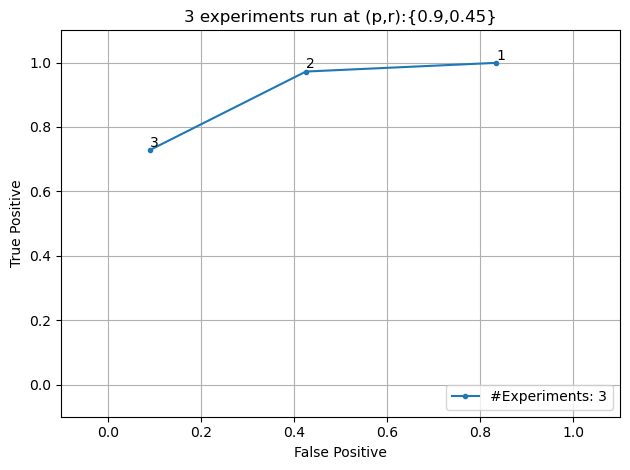

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
2,3,3,0.9,0.45,0.091125,0.908875,0.271,0.729,0.28591


 TP closest to the perfect classifier: 0.729
 FP closest to the perfect classifier: 0.091


In [15]:
# threshold_num_runs = 2 # rule
min_exp_runs = 3
max_exp_runs = 5

total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))

p_list = [0.9]
# p = p_list[2]
r_list = [0.25,0.5,0.75]
r = 0.3

row = []



for total_exp_runs in total_exp_runs_list:
    
    for threshold_num_runs in range(1,total_exp_runs+1):
            # Printer.cyan(threshold_num_runs)
            if total_exp_runs%3!=0:
                continue
            else: pass
            for p in p_list:
            # for r in r_list:
                
                r = 0.45
#                 print("p(successful run|algo = T):",p)
#                 print("p(successful run|algo = F):",r," r = ",k,"*","p")
                exp_T = getBinomProb(total_exp_runs,p)
                exp_F = getBinomProb(total_exp_runs,r)
                exp_dict = {"True":exp_T,"False":exp_F}
                exp_cpt = pd.DataFrame(exp_dict)
                test_keys = []
                test_values = []

                for i in range(total_exp_runs+1):
                    test_keys.append(str(i))
                    if i >= threshold_num_runs:
                        test_values.append([1,0])
                    else:
                        test_values.append([0,1])

                test_results_dict = dict(zip(test_keys, test_values))
                test_results_cpt = pd.DataFrame(test_results_dict) 
                test_results_cpt["States"] = ['Correct','Incorrect']
                test_results_cpt.set_index("States",inplace=True)
                
                # display(test_results_cpt)


                # Create nodes by manually typing in probabilities
                test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                bbn = Bbn() \
                    .add_node(algo) \
                    .add_node(exp1) \
                    .add_node(test_results) \
                    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                join_tree = InferenceController.apply(bbn)

                dffp,dftn = getFPTN(join_tree)
                dffn,dftp = getFNTP(join_tree)
                
#                 print("FP : P(Test=T|Algo=F)=",dffp.tolist())
#                 print("TN : P(Test=F|Algo=F)=",dftn.tolist())
#                 print("FN : P(Test=F|Algo=T)=",dffn.tolist())
#                 print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                fp = dffp.tolist()[0]
                tn = dftn.tolist()[0]
                fn = dffn.tolist()[0]
                tp = dftp.tolist()[0]

                data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                row.append(data)
#                 print("+"*80)
                
    checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
#     display(checkdf)
    
df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
display(df)    

dfs = df.groupby(['n_exp','p','r'])   
fig = go.Figure()
best_dfs = []
subplots_df = []
for i in dfs:
    # display(i[1])
#     fig = go.Figure()
#     fig = px.line(i[1], x="fp", y="tp",text='threshold_exp',hover_data=['n_exp','threshold_exp','p','r'],color='n_exp',markers=True)
#     fig.update_traces(textposition='top center')
#     fig.update_layout(title_text="{Number of experiments vs Threshold Runs at (p,r):{"+str(p)+","+str(r)+"}")
#     fig.show()
    # print(i[1].columns)
    # calculate difference between max and min values
    fpr = i[1].fp.to_numpy()
    tpr = i[1].tp.to_numpy()
    distances = [np.sqrt((1 - tpr[i])**2 + fpr[i]**2) for i in range(len(fpr))]
    i[1]["distances"] = distances
    # find index of the point with minimum distance
    min_index = np.argmin(distances)
    # get the corresponding values of FP and TP
    best_fp = fpr[min_index]
    best_tp = tpr[min_index]
    # find the row with the least value in the 'Salary' column
    best = i[1].loc[i[1]['distances'].idxmin()].to_frame().transpose()
    best['n_exp'] = best['n_exp'].astype(int)
    best['threshold_exp'] = best['threshold_exp'].astype(int)
    best.columns = ["Number of Experiments","Threshold number of successes","p","r","FP","TN","FN","TP","distances"]
    
    p = i[1].p.unique().tolist()[0]
    r = i[1].r.unique().tolist()[0]
    subplots_df.append(i[1])
    plt.plot(i[1].fp,i[1].tp,marker=".")
    for j in range(len(i[1])):
#         print(j,(i[1].iloc[j].fp), (i[1].iloc[j].tp))
        plt.annotate(str(i[1].threshold_exp.tolist()[j]), ((i[1].iloc[j].fp), (i[1].iloc[j].tp)+0.01))
    plt.legend(["#Experiments: "+str(i[1].n_exp.unique().tolist()[0])]  ,loc='lower right')
    plt.xlabel("False Positive")
    plt.ylabel("True Positive")
    plt.title(str(i[1].n_exp.unique().tolist()[0])+" experiments run at (p,r):{"+str(p)+","+str(r)+"}")
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    display(best)
    best_dfs.append(best)
    Printer.green(f"TP closest to the perfect classifier: {best_tp:.3f}")
    Printer.orange(f"FP closest to the perfect classifier: {best_fp:.3f}")
    
result = pd.concat(best_dfs, axis=0, ignore_index=True)
# drop a column
result = result.drop('distances', axis=1)
result = result.round({'TP':4,'TN':4,'FP':4,'FN':4})
# convert the 'float_col' column to integer

# display(result)
rvals = '-'.join(str(e) for e in result.r.unique().tolist())
pvals = '-'.join(str(e) for e in result.p.unique().tolist())
fname = '-'.join(['p',pvals,'r',rvals])+".csv"
result.to_csv(fname, index=False)


# plt.figure(figsize=(16,4))
# for k in range(1,len(subplots_df)+1):
#         p = subplots_df[k-1].p.unique().tolist()[0]
#         r = subplots_df[k-1].r.unique().tolist()[0]
#         val = k
#         if(val%3==0):
#                 val = 3
#         else:
#                 val = val%3
#         plt.subplot(1,3,val)
#         plt.plot(subplots_df[k-1].fp,subplots_df[k-1].tp,marker=".")
#         for j in range(len(subplots_df[k-1])):
#         #         print(j,(i[1].iloc[j].fp), (i[1].iloc[j].tp))
#                 plt.annotate(str(subplots_df[k-1].threshold_exp.tolist()[j]), ((subplots_df[k-1].iloc[j].fp), (subplots_df[k-1].iloc[j].tp)+0.01))
#         plt.legend(["#Experiments: "+str(subplots_df[k-1].n_exp.unique().tolist()[0])]  ,loc='lower right')
#         plt.xlabel("False Positive")
#         plt.ylabel("True Positive")
#         plt.title(str(subplots_df[k-1].n_exp.unique().tolist()[0])+" experiments run at (p,r):{"+str(p)+","+str(r)+"}")
#         plt.xlim([-0.1,1.1])
#         plt.ylim([-0.1,1.1])
#         plt.grid(True)
#         if(k)%3==0:
#                 fig = plt.gcf()
#                 plt.tight_layout()
#                 plt.show()
#                 fig.savefig(str(subplots_df[k-1].n_exp.unique().tolist()[0])+" experiments run at p-"+str(p)+".png", dpi=300)
#                 plt.figure(figsize=(16,4))



# Case 2

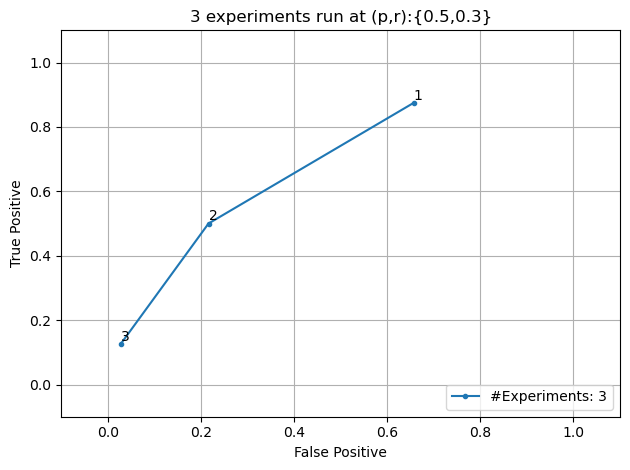

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
3,3,2,0.5,0.3,0.216,0.784,0.5,0.5,0.544661


 TP closest to the perfect classifier: 0.500
 FP closest to the perfect classifier: 0.216


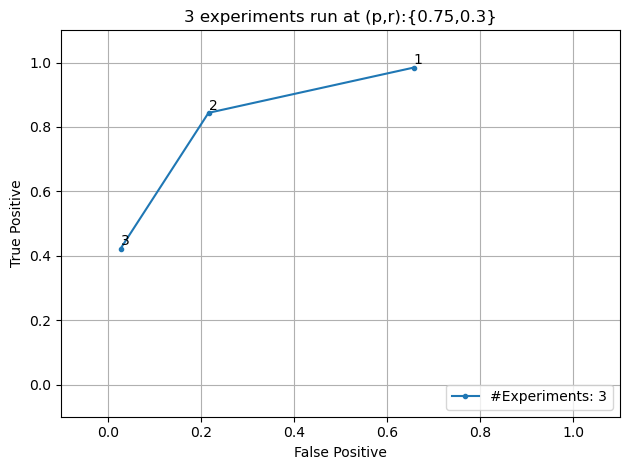

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
4,3,2,0.75,0.3,0.216,0.784,0.15625,0.84375,0.26659


 TP closest to the perfect classifier: 0.844
 FP closest to the perfect classifier: 0.216


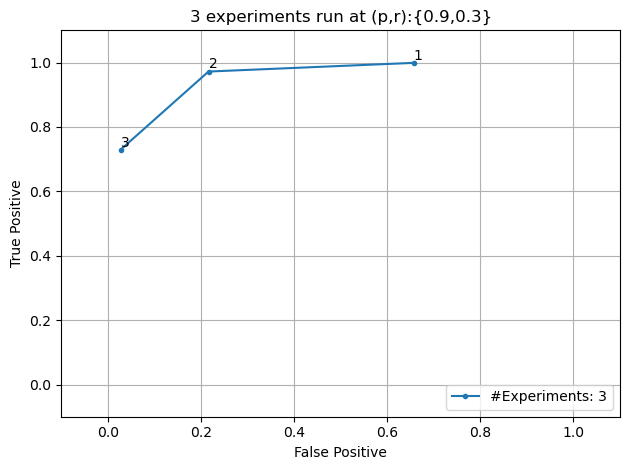

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
5,3,2,0.9,0.3,0.216,0.784,0.028,0.972,0.217807


 TP closest to the perfect classifier: 0.972
 FP closest to the perfect classifier: 0.216


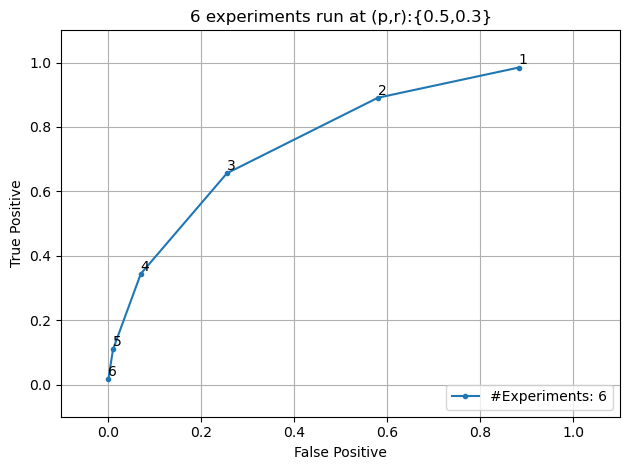

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
15,6,3,0.5,0.3,0.25569,0.74431,0.34375,0.65625,0.428417


 TP closest to the perfect classifier: 0.656
 FP closest to the perfect classifier: 0.256


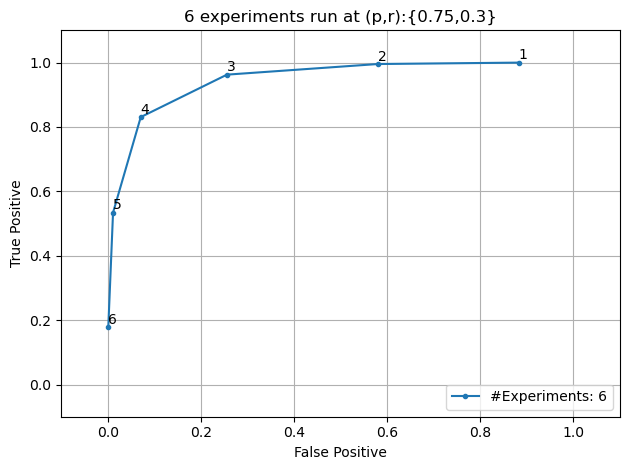

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
19,6,4,0.75,0.3,0.07047,0.92953,0.169434,0.830566,0.183504


 TP closest to the perfect classifier: 0.831
 FP closest to the perfect classifier: 0.070


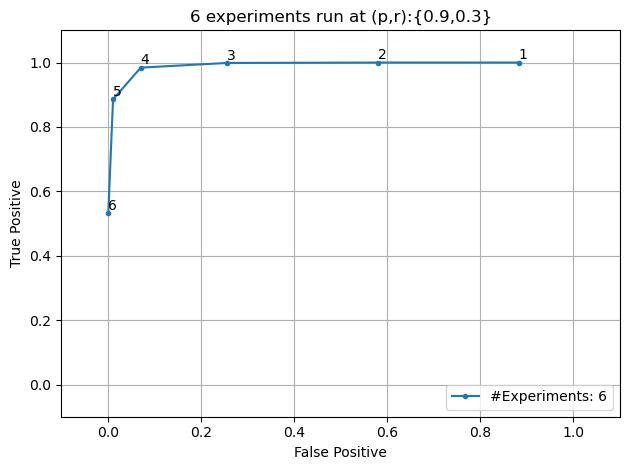

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
20,6,4,0.9,0.3,0.07047,0.92953,0.01585,0.98415,0.07223


 TP closest to the perfect classifier: 0.984
 FP closest to the perfect classifier: 0.070


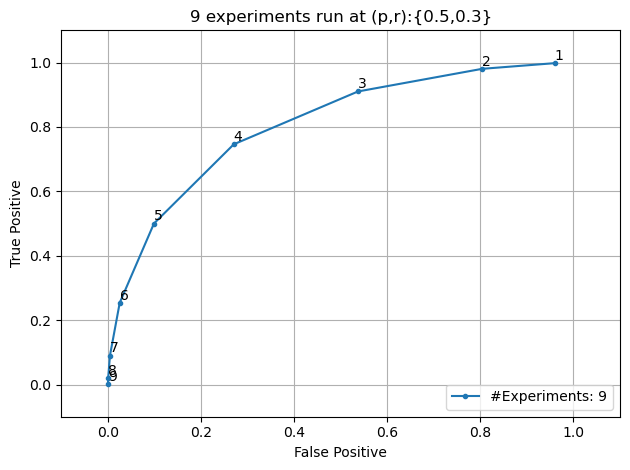

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
36,9,4,0.5,0.3,0.270341,0.729659,0.253906,0.746094,0.370881


 TP closest to the perfect classifier: 0.746
 FP closest to the perfect classifier: 0.270


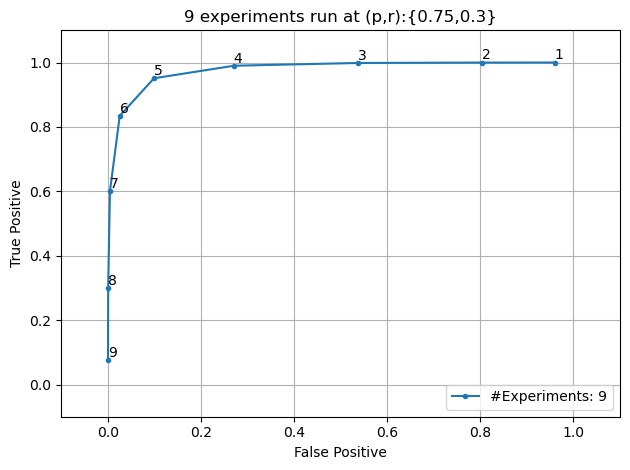

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
40,9,5,0.75,0.3,0.098809,0.901191,0.048927,0.951073,0.110259


 TP closest to the perfect classifier: 0.951
 FP closest to the perfect classifier: 0.099


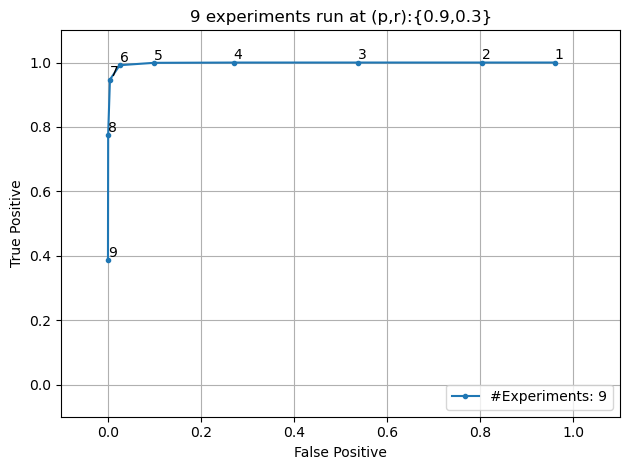

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
44,9,6,0.9,0.3,0.025295,0.974705,0.008331,0.991669,0.026631


 TP closest to the perfect classifier: 0.992
 FP closest to the perfect classifier: 0.025


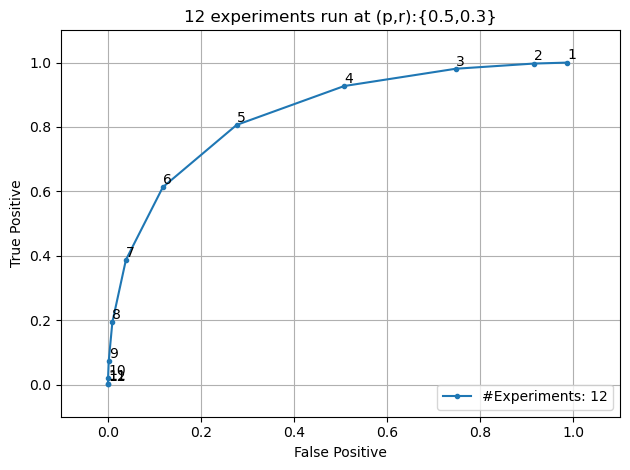

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
66,12,5,0.5,0.3,0.276345,0.723655,0.193848,0.806152,0.337555


 TP closest to the perfect classifier: 0.806
 FP closest to the perfect classifier: 0.276


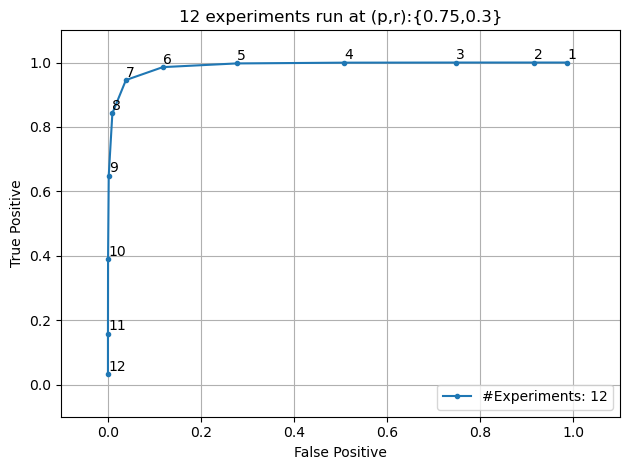

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
73,12,7,0.75,0.3,0.038601,0.961399,0.054402,0.945598,0.066706


 TP closest to the perfect classifier: 0.946
 FP closest to the perfect classifier: 0.039


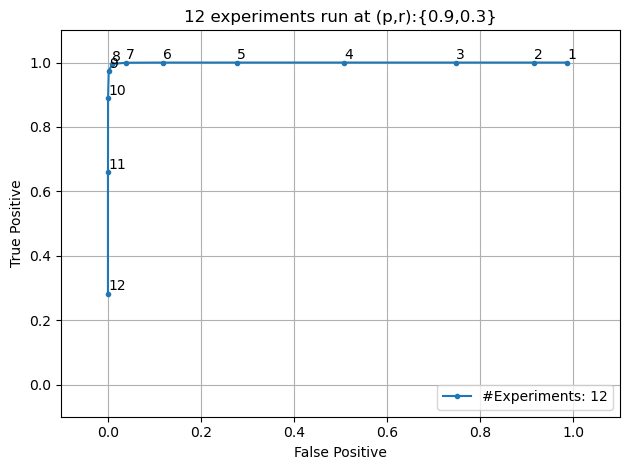

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
77,12,8,0.9,0.3,0.009489,0.990511,0.004329,0.995671,0.01043


 TP closest to the perfect classifier: 0.996
 FP closest to the perfect classifier: 0.009


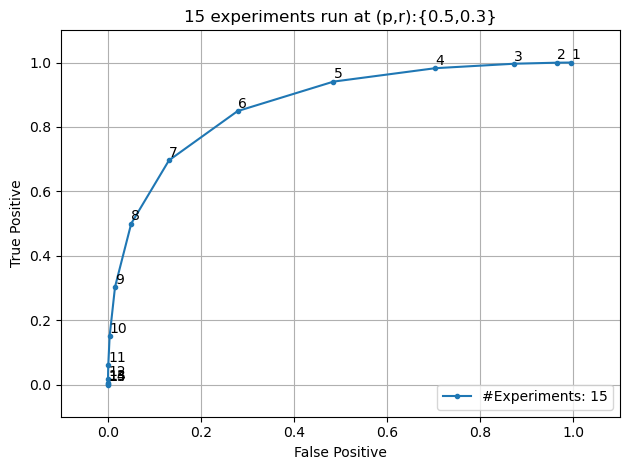

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
105,15,6,0.5,0.3,0.278379,0.721621,0.150879,0.849121,0.316637


 TP closest to the perfect classifier: 0.849
 FP closest to the perfect classifier: 0.278


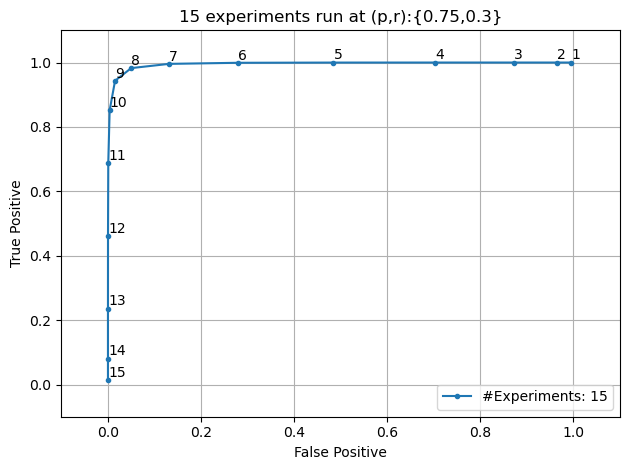

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
112,15,8,0.75,0.3,0.050013,0.949987,0.0173,0.9827,0.05292


 TP closest to the perfect classifier: 0.983
 FP closest to the perfect classifier: 0.050


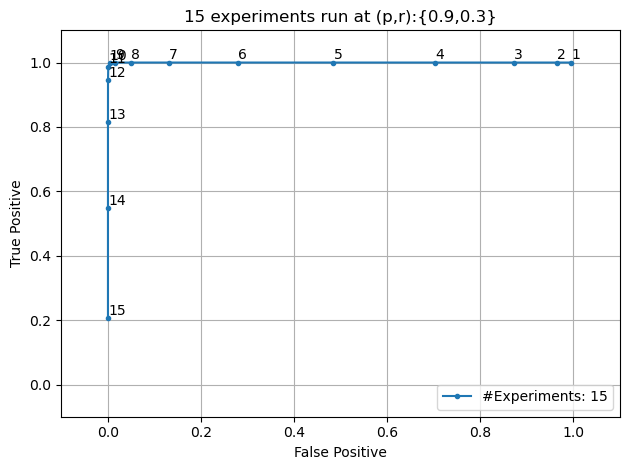

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
119,15,10,0.9,0.3,0.003653,0.996347,0.00225,0.99775,0.00429


 TP closest to the perfect classifier: 0.998
 FP closest to the perfect classifier: 0.004


,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP
0,3,2,0.50,0.3,0.2160,0.7840,0.5000,0.5000
1,3,2,0.75,0.3,0.2160,0.7840,0.1562,0.8438
2,3,2,0.90,0.3,0.2160,0.7840,0.0280,0.9720
3,6,3,0.50,0.3,0.2557,0.7443,0.3438,0.6562
4,6,4,0.75,0.3,0.0705,0.9295,0.1694,0.8306
5,6,4,0.90,0.3,0.0705,0.9295,0.0158,0.9842
6,9,4,0.50,0.3,0.2703,0.7297,0.2539,0.7461
7,9,5,0.75,0.3,0.0988,0.9012,0.0489,0.9511
8,9,6,0.90,0.3,0.0253,0.9747,0.0083,0.9917
9,12,5,0.50,0.3,0.2763,0.7237,0.1938,0.8062


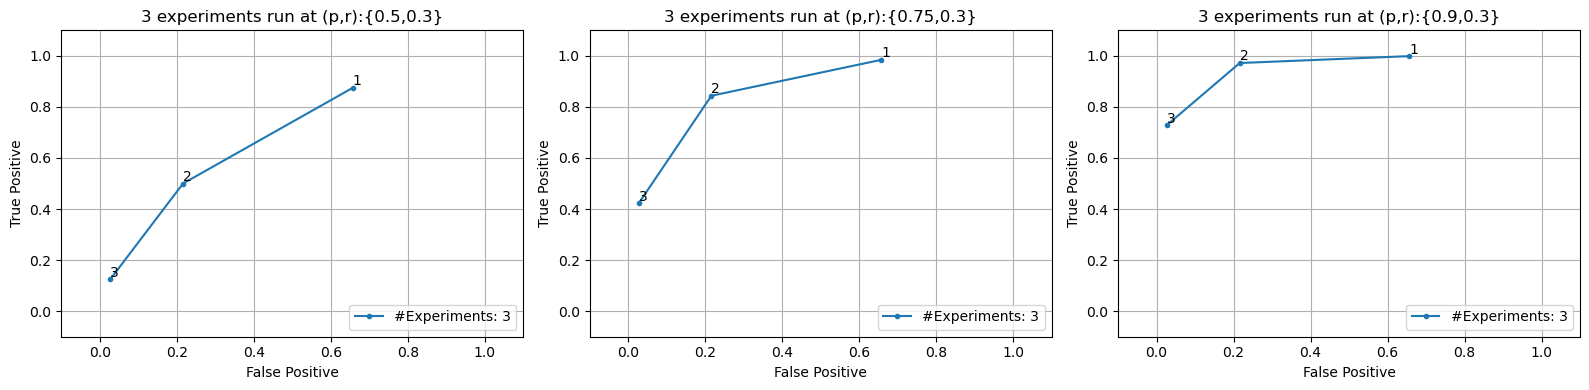

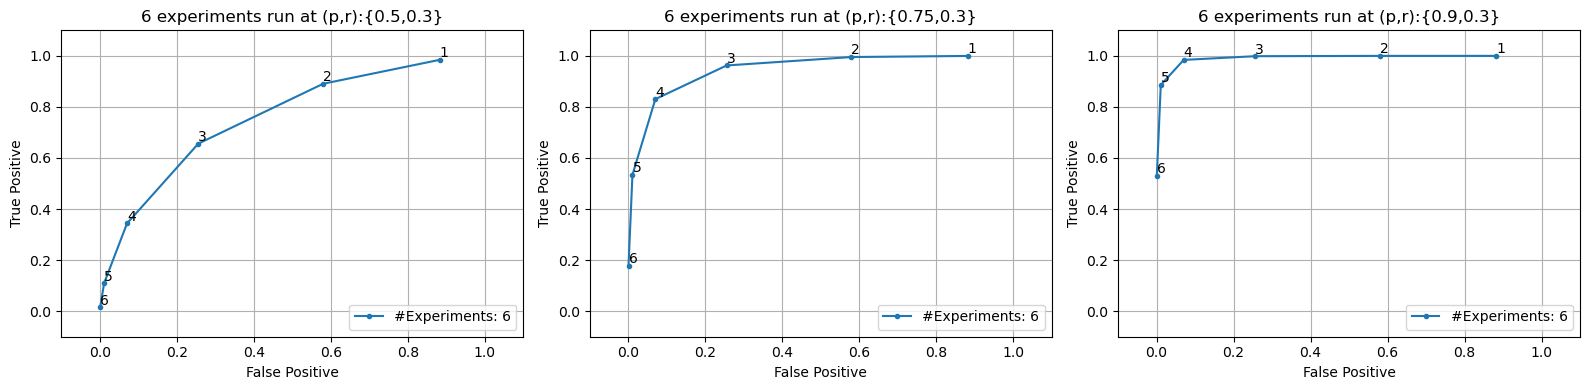

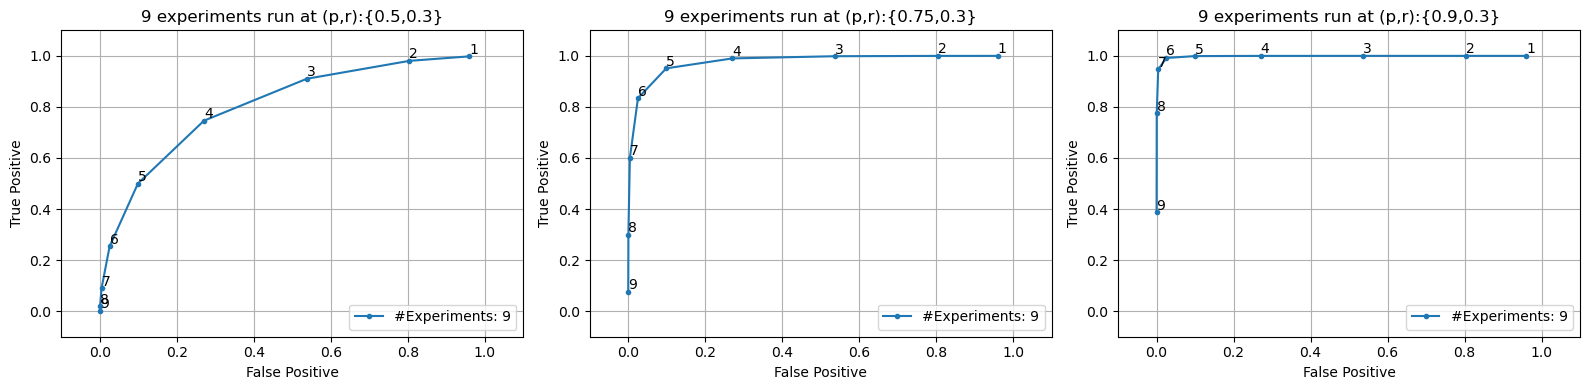

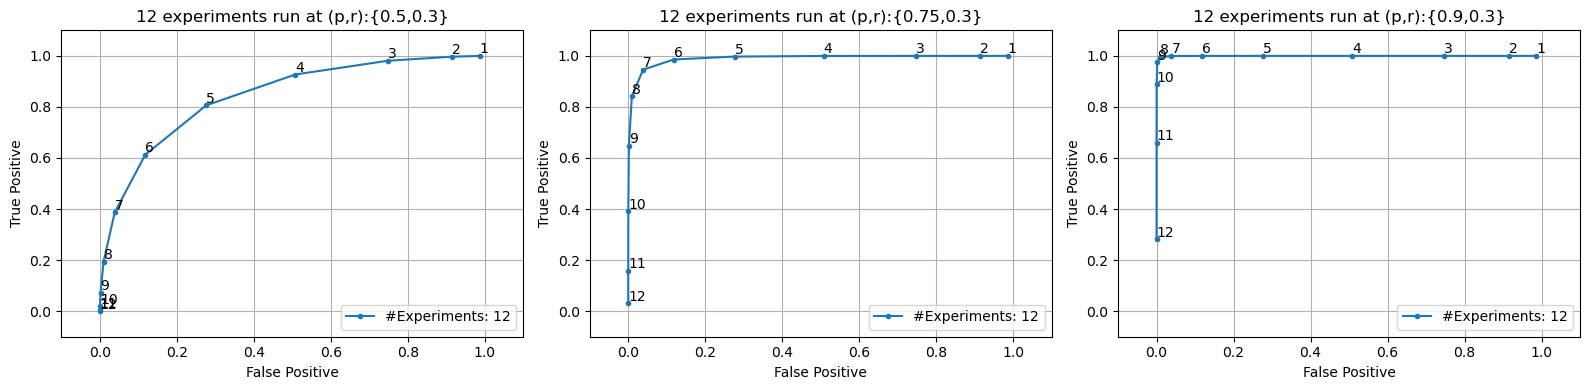

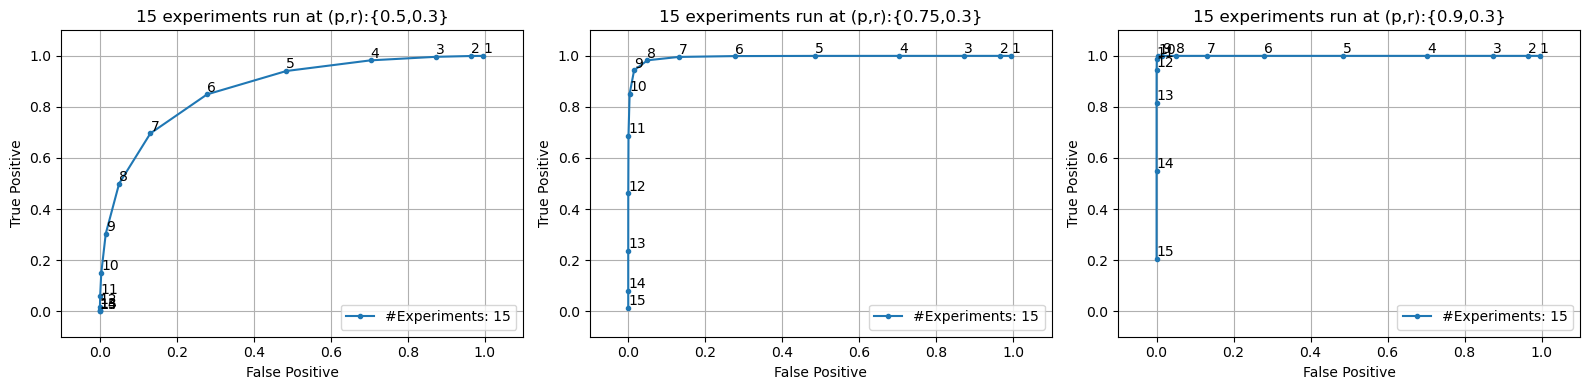

<Figure size 1600x400 with 0 Axes>

In [249]:
# threshold_num_runs = 2 # rule
min_exp_runs = 3
max_exp_runs = 15

total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))

p_list = [0.5,0.75,0.9]
# p = p_list[2]
# r_list = [0.25,0.5,0.75]
r = 0.3

row = []



for total_exp_runs in total_exp_runs_list:
    
    for threshold_num_runs in range(1,total_exp_runs+1):
            if total_exp_runs%3!=0:
                continue
            else: pass
            for p in p_list:
            # for r in r_list:
                
                # r = 0.45
#                 print("p(successful run|algo = T):",p)
#                 print("p(successful run|algo = F):",r," r = ",k,"*","p")
                exp_T = getBinomProb(total_exp_runs,p)
                exp_F = getBinomProb(total_exp_runs,r)
                exp_dict = {"True":exp_T,"False":exp_F}
                exp_cpt = pd.DataFrame(exp_dict)
                test_keys = []
                test_values = []

                for i in range(total_exp_runs+1):
                    test_keys.append(str(i))
                    if i >= threshold_num_runs:
                        test_values.append([1,0])
                    else:
                        test_values.append([0,1])

                test_results_dict = dict(zip(test_keys, test_values))
                test_results_cpt = pd.DataFrame(test_results_dict) 
                test_results_cpt["States"] = ['Correct','Incorrect']
                test_results_cpt.set_index("States",inplace=True)
                
                # display(test_results_cpt)


                # Create nodes by manually typing in probabilities
                test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                bbn = Bbn() \
                    .add_node(algo) \
                    .add_node(exp1) \
                    .add_node(test_results) \
                    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                join_tree = InferenceController.apply(bbn)

                dffp,dftn = getFPTN(join_tree)
                dffn,dftp = getFNTP(join_tree)
                
#                 print("FP : P(Test=T|Algo=F)=",dffp.tolist())
#                 print("TN : P(Test=F|Algo=F)=",dftn.tolist())
#                 print("FN : P(Test=F|Algo=T)=",dffn.tolist())
#                 print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                fp = dffp.tolist()[0]
                tn = dftn.tolist()[0]
                fn = dffn.tolist()[0]
                tp = dftp.tolist()[0]

                data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                row.append(data)
#                 print("+"*80)
                
    checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
#     display(checkdf)
    
df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
# display(df.head())    

dfs = df.groupby(['n_exp','p','r'])   
fig = go.Figure()
best_dfs = []
subplots_df = []
for i in dfs:
#     display(i[1])
#     fig = go.Figure()
#     fig = px.line(i[1], x="fp", y="tp",text='threshold_exp',hover_data=['n_exp','threshold_exp','p','r'],color='n_exp',markers=True)
#     fig.update_traces(textposition='top center')
#     fig.update_layout(title_text="{Number of experiments vs Threshold Runs at (p,r):{"+str(p)+","+str(r)+"}")
#     fig.show()
    # print(i[1].columns)
    # calculate difference between max and min values
    fpr = i[1].fp.to_numpy()
    tpr = i[1].tp.to_numpy()
    distances = [np.sqrt((1 - tpr[i])**2 + fpr[i]**2) for i in range(len(fpr))]
    i[1]["distances"] = distances
    # find index of the point with minimum distance
    min_index = np.argmin(distances)
    # get the corresponding values of FP and TP
    best_fp = fpr[min_index]
    best_tp = tpr[min_index]
    # find the row with the least value in the 'Salary' column
    best = i[1].loc[i[1]['distances'].idxmin()].to_frame().transpose()
    best['n_exp'] = best['n_exp'].astype(int)
    best['threshold_exp'] = best['threshold_exp'].astype(int)
    best.columns = ["Number of Experiments","Threshold number of successes","p","r","FP","TN","FN","TP","distances"]
    
    p = i[1].p.unique().tolist()[0]
    r = i[1].r.unique().tolist()[0]
    subplots_df.append(i[1])
    plt.plot(i[1].fp,i[1].tp,marker=".")
    for j in range(len(i[1])):
#         print(j,(i[1].iloc[j].fp), (i[1].iloc[j].tp))
        plt.annotate(str(i[1].threshold_exp.tolist()[j]), ((i[1].iloc[j].fp), (i[1].iloc[j].tp)+0.01))
    plt.legend(["#Experiments: "+str(i[1].n_exp.unique().tolist()[0])]  ,loc='lower right')
    plt.xlabel("False Positive")
    plt.ylabel("True Positive")
    plt.title(str(i[1].n_exp.unique().tolist()[0])+" experiments run at (p,r):{"+str(p)+","+str(r)+"}")
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    display(best)
    best_dfs.append(best)
    Printer.green(f"TP closest to the perfect classifier: {best_tp:.3f}")
    Printer.orange(f"FP closest to the perfect classifier: {best_fp:.3f}")
    
result = pd.concat(best_dfs, axis=0, ignore_index=True)
# drop a column
result = result.drop('distances', axis=1)
result = result.round({'TP':4,'TN':4,'FP':4,'FN':4})
# convert the 'float_col' column to integer

display(result)
rvals = '-'.join(str(e) for e in result.r.unique().tolist())
pvals = '-'.join(str(e) for e in result.p.unique().tolist())
fname = '-'.join(['p',pvals,'r',rvals])+".csv"
result.to_csv(fname, index=False)


plt.figure(figsize=(16,4))
for k in range(1,len(subplots_df)+1):
        p = subplots_df[k-1].p.unique().tolist()[0]
        r = subplots_df[k-1].r.unique().tolist()[0]
        val = k
        if(val%3==0):
                val = 3
        else:
                val = val%3
        plt.subplot(1,3,val)
        plt.plot(subplots_df[k-1].fp,subplots_df[k-1].tp,marker=".")
        for j in range(len(subplots_df[k-1])):
        #         print(j,(i[1].iloc[j].fp), (i[1].iloc[j].tp))
                plt.annotate(str(subplots_df[k-1].threshold_exp.tolist()[j]), ((subplots_df[k-1].iloc[j].fp), (subplots_df[k-1].iloc[j].tp)+0.01))
        plt.legend(["#Experiments: "+str(subplots_df[k-1].n_exp.unique().tolist()[0])]  ,loc='lower right')
        plt.xlabel("False Positive")
        plt.ylabel("True Positive")
        plt.title(str(subplots_df[k-1].n_exp.unique().tolist()[0])+" experiments run at (p,r):{"+str(p)+","+str(r)+"}")
        plt.xlim([-0.1,1.1])
        plt.ylim([-0.1,1.1])
        plt.grid(True)
        if(k)%3==0:
                fig = plt.gcf()
                plt.tight_layout()
                plt.show()
                fig.savefig(str(subplots_df[k-1].n_exp.unique().tolist()[0])+" experiments run at r-"+str(r)+".png", dpi=300)
                plt.figure(figsize=(16,4))



# Case 4

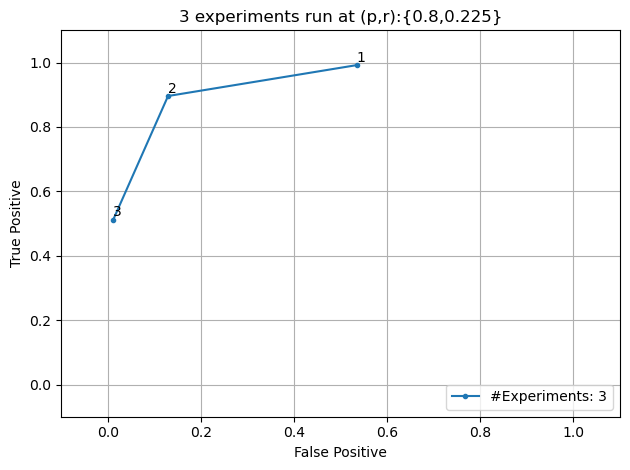

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
1,3,2,0.8,0.225,0.129094,0.870906,0.104,0.896,0.165775


 TP closest to the perfect classifier: 0.896
 FP closest to the perfect classifier: 0.129


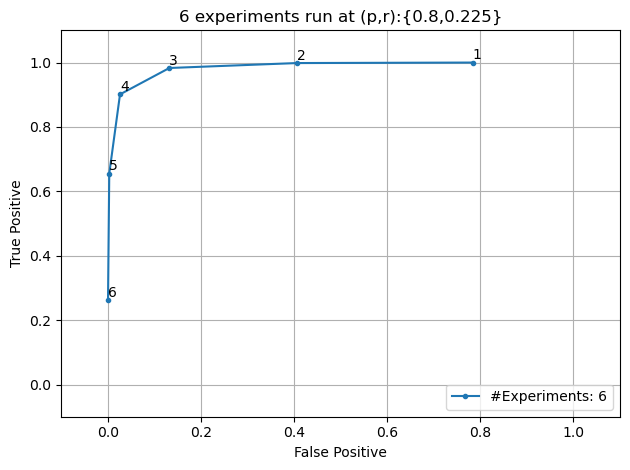

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
6,6,4,0.8,0.225,0.025901,0.974099,0.09888,0.90112,0.102216


 TP closest to the perfect classifier: 0.901
 FP closest to the perfect classifier: 0.026


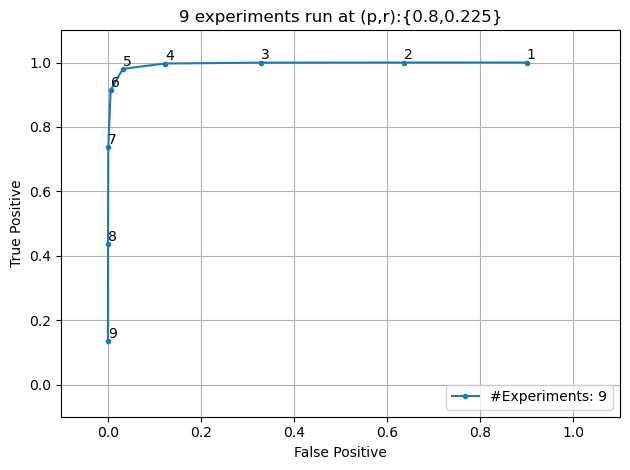

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
13,9,5,0.8,0.225,0.031963,0.968037,0.019581,0.980419,0.037484


 TP closest to the perfect classifier: 0.980
 FP closest to the perfect classifier: 0.032


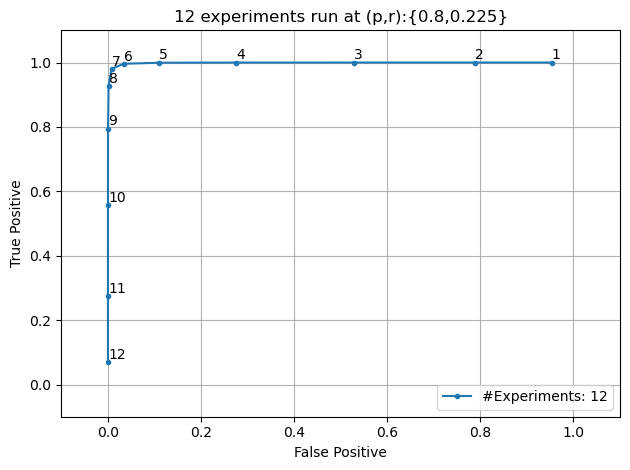

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
24,12,7,0.8,0.225,0.007802,0.992198,0.019405,0.980595,0.020915


 TP closest to the perfect classifier: 0.981
 FP closest to the perfect classifier: 0.008


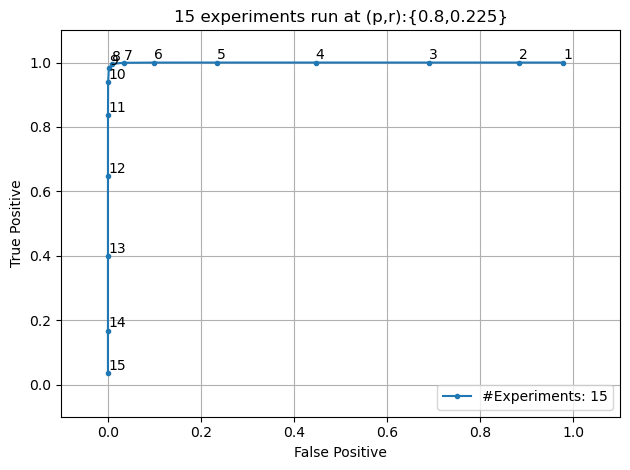

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
37,15,8,0.8,0.225,0.00902,0.99098,0.00424,0.99576,0.009967


 TP closest to the perfect classifier: 0.996
 FP closest to the perfect classifier: 0.009


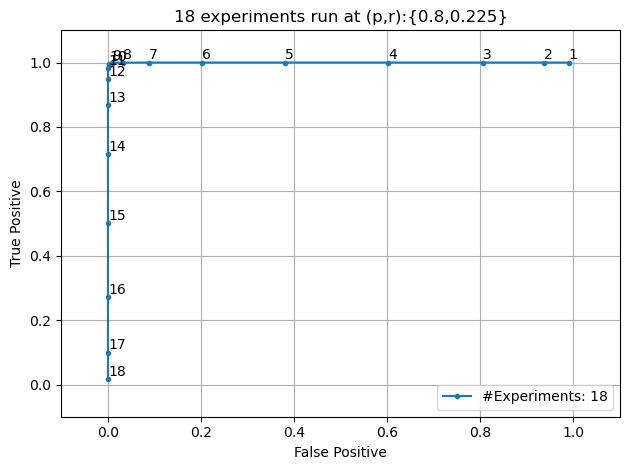

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
54,18,10,0.8,0.225,0.002371,0.997629,0.004252,0.995748,0.004869


 TP closest to the perfect classifier: 0.996
 FP closest to the perfect classifier: 0.002


,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP
0,3,2,0.8,0.225,0.1291,0.8709,0.1040,0.8960
1,6,4,0.8,0.225,0.0259,0.9741,0.0989,0.9011
2,9,5,0.8,0.225,0.0320,0.9680,0.0196,0.9804
3,12,7,0.8,0.225,0.0078,0.9922,0.0194,0.9806
4,15,8,0.8,0.225,0.0090,0.9910,0.0042,0.9958
5,18,10,0.8,0.225,0.0024,0.9976,0.0043,0.9957


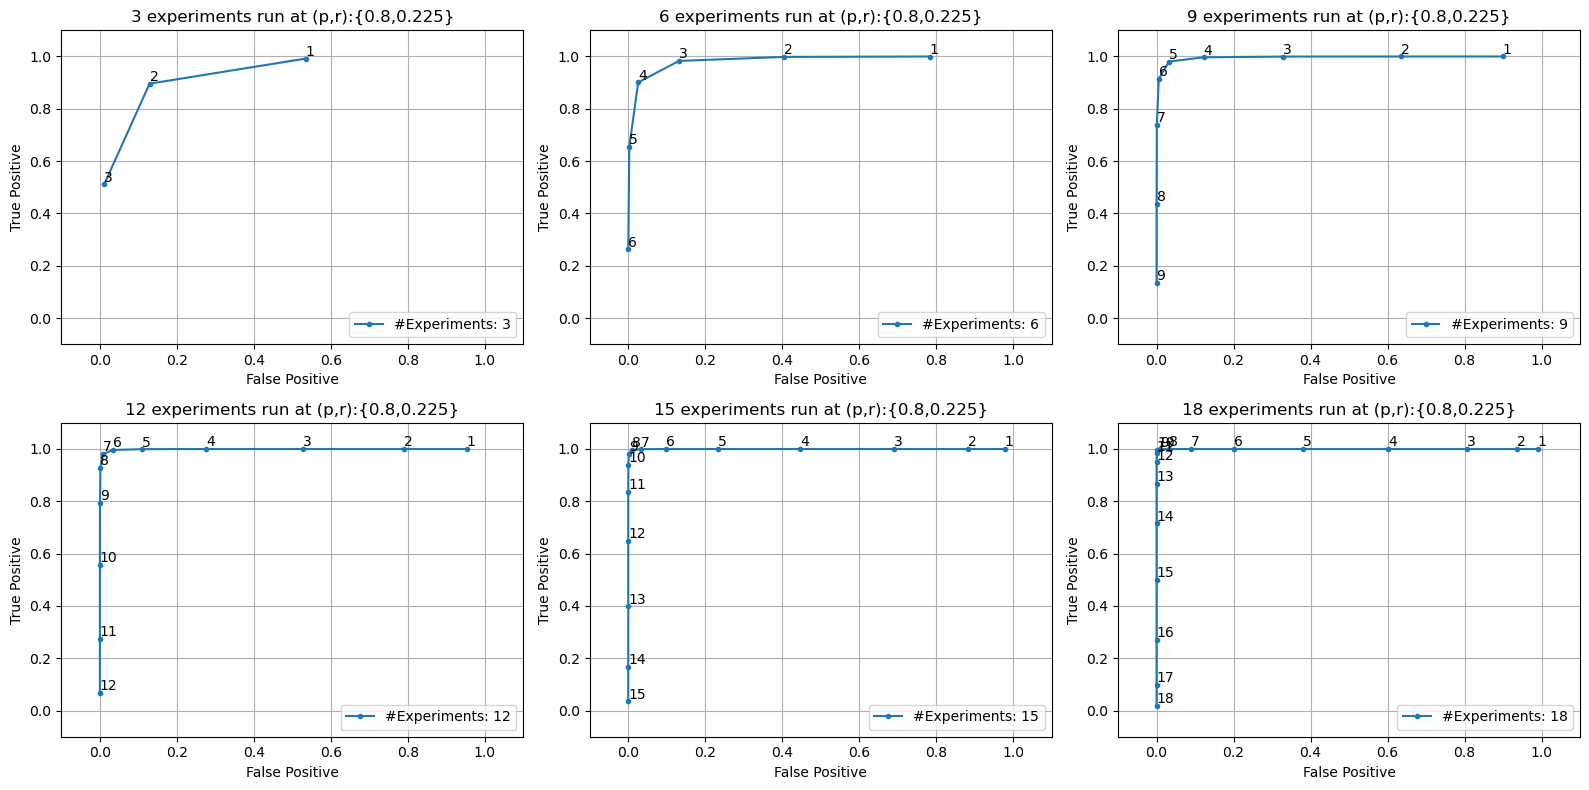

In [314]:
# threshold_num_runs = 2 # rule
min_exp_runs = 3
max_exp_runs = 18

total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))

p_list = [0.8]

r_list = [0.25,0.5,0.75]

row = []



for total_exp_runs in total_exp_runs_list:
    
    for threshold_num_runs in range(1,total_exp_runs+1):
            if total_exp_runs%3!=0:
                continue
            else: pass
            for p in p_list:
            # for r in r_list:
                
                r = 0.225
#                 print("p(successful run|algo = T):",p)
#                 print("p(successful run|algo = F):",r," r = ",k,"*","p")
                exp_T = getBinomProb(total_exp_runs,p)
                exp_F = getBinomProb(total_exp_runs,r)
                exp_dict = {"True":exp_T,"False":exp_F}
                exp_cpt = pd.DataFrame(exp_dict)
                test_keys = []
                test_values = []

                for i in range(total_exp_runs+1):
                    test_keys.append(str(i))
                    if i >= threshold_num_runs:
                        test_values.append([1,0])
                    else:
                        test_values.append([0,1])

                test_results_dict = dict(zip(test_keys, test_values))
                test_results_cpt = pd.DataFrame(test_results_dict) 
                test_results_cpt["States"] = ['Correct','Incorrect']
                test_results_cpt.set_index("States",inplace=True)
                
                # display(test_results_cpt)


                # Create nodes by manually typing in probabilities
                test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                bbn = Bbn() \
                    .add_node(algo) \
                    .add_node(exp1) \
                    .add_node(test_results) \
                    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                join_tree = InferenceController.apply(bbn)

                dffp,dftn = getFPTN(join_tree)
                dffn,dftp = getFNTP(join_tree)
                
#                 print("FP : P(Test=T|Algo=F)=",dffp.tolist())
#                 print("TN : P(Test=F|Algo=F)=",dftn.tolist())
#                 print("FN : P(Test=F|Algo=T)=",dffn.tolist())
#                 print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                fp = dffp.tolist()[0]
                tn = dftn.tolist()[0]
                fn = dffn.tolist()[0]
                tp = dftp.tolist()[0]

                data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                row.append(data)
#                 print("+"*80)
                
    checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
#     display(checkdf)
    
df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
# display(df.head())    

dfs = df.groupby(['n_exp','p','r'])   
fig = go.Figure()
best_dfs = []
subplots_df = []
for i in dfs:
#     display(i[1])
#     fig = go.Figure()
#     fig = px.line(i[1], x="fp", y="tp",text='threshold_exp',hover_data=['n_exp','threshold_exp','p','r'],color='n_exp',markers=True)
#     fig.update_traces(textposition='top center')
#     fig.update_layout(title_text="{Number of experiments vs Threshold Runs at (p,r):{"+str(p)+","+str(r)+"}")
#     fig.show()
    # print(i[1].columns)
    # calculate difference between max and min values
    fpr = i[1].fp.to_numpy()
    tpr = i[1].tp.to_numpy()
    distances = [np.sqrt((1 - tpr[i])**2 + fpr[i]**2) for i in range(len(fpr))]
    i[1]["distances"] = distances
    # find index of the point with minimum distance
    min_index = np.argmin(distances)
    # get the corresponding values of FP and TP
    best_fp = fpr[min_index]
    best_tp = tpr[min_index]
    # find the row with the least value in the 'Salary' column
    best = i[1].loc[i[1]['distances'].idxmin()].to_frame().transpose()
    best['n_exp'] = best['n_exp'].astype(int)
    best['threshold_exp'] = best['threshold_exp'].astype(int)
    best.columns = ["Number of Experiments","Threshold number of successes","p","r","FP","TN","FN","TP","distances"]
    
    p = i[1].p.unique().tolist()[0]
    r = i[1].r.unique().tolist()[0]
    subplots_df.append(i[1])
    plt.plot(i[1].fp,i[1].tp,marker=".")
    for j in range(len(i[1])):
#         print(j,(i[1].iloc[j].fp), (i[1].iloc[j].tp))
        plt.annotate(str(i[1].threshold_exp.tolist()[j]), ((i[1].iloc[j].fp), (i[1].iloc[j].tp)+0.01))
    plt.legend(["#Experiments: "+str(i[1].n_exp.unique().tolist()[0])]  ,loc='lower right')
    plt.xlabel("False Positive")
    plt.ylabel("True Positive")
    plt.title(str(i[1].n_exp.unique().tolist()[0])+" experiments run at (p,r):{"+str(p)+","+str(r)+"}")
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    display(best)
    best_dfs.append(best)
    Printer.green(f"TP closest to the perfect classifier: {best_tp:.3f}")
    Printer.orange(f"FP closest to the perfect classifier: {best_fp:.3f}")
    
result = pd.concat(best_dfs, axis=0, ignore_index=True)
# drop a column
result = result.drop('distances', axis=1)
result = result.round({'TP':4,'TN':4,'FP':4,'FN':4})
# convert the 'float_col' column to integer

display(result)
rvals = '-'.join(str(e) for e in result.r.unique().tolist())
pvals = '-'.join(str(e) for e in result.p.unique().tolist())
fname = '-'.join(['p',pvals,'r',rvals])+".csv"
result.to_csv(fname, index=False)

# display(result)

plt.figure(figsize=(16,8))
for k in range(1,len(subplots_df)+1):
        p = subplots_df[k-1].p.unique().tolist()[0]
        r = subplots_df[k-1].r.unique().tolist()[0]
        val = k
        plt.subplot(2,3,val)
        plt.plot(subplots_df[k-1].fp,subplots_df[k-1].tp,marker=".")
        for j in range(len(subplots_df[k-1])):
        #         print(j,(i[1].iloc[j].fp), (i[1].iloc[j].tp))
                plt.annotate(str(subplots_df[k-1].threshold_exp.tolist()[j]), ((subplots_df[k-1].iloc[j].fp), (subplots_df[k-1].iloc[j].tp)+0.01))
        plt.legend(["#Experiments: "+str(subplots_df[k-1].n_exp.unique().tolist()[0])]  ,loc='lower right')
        plt.xlabel("False Positive")
        plt.ylabel("True Positive")
        plt.title(str(subplots_df[k-1].n_exp.unique().tolist()[0])+" experiments run at (p,r):{"+str(p)+","+str(r)+"}")
        plt.xlim([-0.1,1.1])
        plt.ylim([-0.1,1.1])
        plt.grid(True)
       
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig("case4-max-"+str(max_exp_runs)+"-experiments run at p-"+str(p)+"-r-"+str(r)+"_case4.png", dpi=300)
                # plt.figure(figsize=(16,4))



,n_exp,threshold_exp,p,r,fp,tn,fn,tp,distances
4,5,3,0.6,0.25,0.103516,0.896484,0.31744,0.68256,0.333892
5,5,3,0.9,0.25,0.103516,0.896484,0.00856,0.99144,0.103869


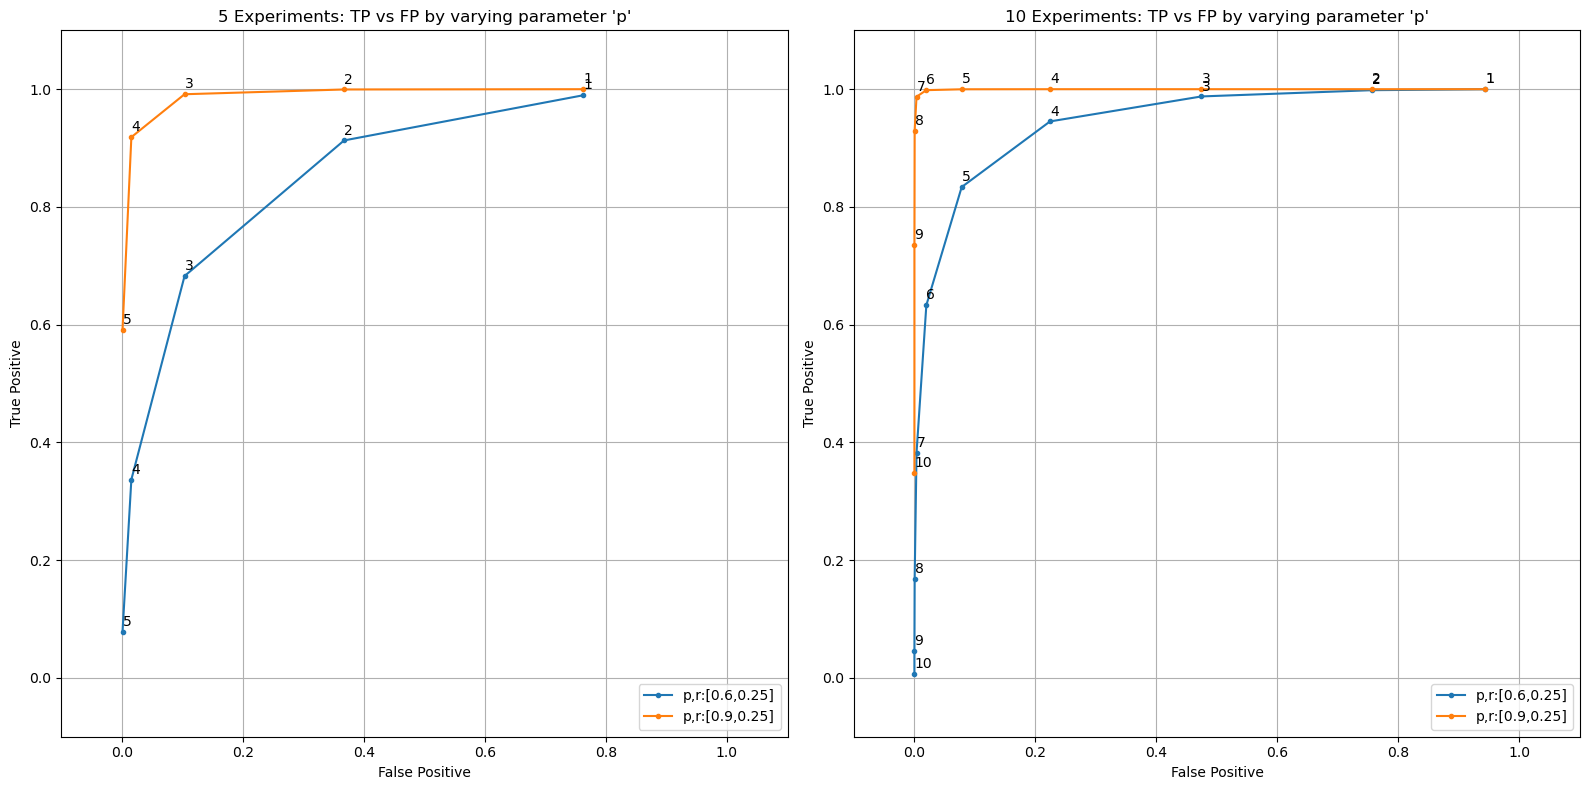

In [62]:

# sns.set_theme()
# threshold_num_runs = 2 # rule
min_exp_runs = 5
max_exp_runs = 10

total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))

p_list = [0.6,0.9]
# p_list = [0.9]
# p = p_list[2]
r_list = [0.25]
r = r_list[0]

row = []



for total_exp_runs in total_exp_runs_list:
    
    for threshold_num_runs in range(1,total_exp_runs+1):
            # Printer.cyan(threshold_num_runs)
            # if total_exp_runs%3!=0:
            #     continue
            # else: pass
            for p in p_list:
            # for r in r_list:
            

                # print("p(successful run|algo = T):",p)
                # print("p(successful run|algo = F):",r)#," r = ",k,"*","p")
                exp_T = getBinomProb(total_exp_runs,p)
                exp_F = getBinomProb(total_exp_runs,r)
                exp_dict = {"True":exp_T,"False":exp_F}
                exp_cpt = pd.DataFrame(exp_dict)
                test_keys = []
                test_values = []

                for i in range(total_exp_runs+1):
                    test_keys.append(str(i))
                    if i >= threshold_num_runs:
                        test_values.append([1,0])
                    else:
                        test_values.append([0,1])

                test_results_dict = dict(zip(test_keys, test_values))
                test_results_cpt = pd.DataFrame(test_results_dict) 
                test_results_cpt["States"] = ['Correct','Incorrect']
                test_results_cpt.set_index("States",inplace=True)
                
                # display(test_results_cpt)


                # Create nodes by manually typing in probabilities
                test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                bbn = Bbn() \
                    .add_node(algo) \
                    .add_node(exp1) \
                    .add_node(test_results) \
                    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                join_tree = InferenceController.apply(bbn)

                dffp,dftn = getFPTN(join_tree)
                dffn,dftp = getFNTP(join_tree)
                
                # print("FP : P(Test=T|Algo=F)=",dffp.tolist())
                # print("TN : P(Test=F|Algo=F)=",dftn.tolist())
                # print("FN : P(Test=F|Algo=T)=",dffn.tolist())
                # print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                fp = dffp.tolist()[0]
                tn = dftn.tolist()[0]
                fn = dffn.tolist()[0]
                tp = dftp.tolist()[0]

                data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                row.append(data)
                
    checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
#     display(checkdf)
    
df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
# display(df)    

dfs = df.groupby(['n_exp','p','r'])   
fig = go.Figure()
best_dfs = []
subplots_df = []
for i in dfs:
    # display(i[1])
#     fig = go.Figure()
#     fig = px.line(i[1], x="fp", y="tp",text='threshold_exp',hover_data=['n_exp','threshold_exp','p','r'],color='n_exp',markers=True)
#     fig.update_traces(textposition='top center')
#     fig.update_layout(title_text="{Number of experiments vs Threshold Runs at (p,r):{"+str(p)+","+str(r)+"}")
#     fig.show()
    # print(i[1].columns)
    # calculate difference between max and min values
    fpr = i[1].fp.to_numpy()
    tpr = i[1].tp.to_numpy()
    distances = [np.sqrt((1 - tpr[i])**2 + fpr[i]**2) for i in range(len(fpr))]
    i[1]["distances"] = distances
    # find index of the point with minimum distance
    min_index = np.argmin(distances)
    # get the corresponding values of FP and TP
    best_fp = fpr[min_index]
    best_tp = tpr[min_index]
    # find the row with the least value in the 'Salary' column
    best = i[1].loc[i[1]['distances'].idxmin()].to_frame().transpose()
    best['n_exp'] = best['n_exp'].astype(int)
    best['threshold_exp'] = best['threshold_exp'].astype(int)
    best.columns = ["Number of Experiments","Threshold number of successes","p","r","FP","TN","FN","TP","distances"]
    
    p = i[1].p.unique().tolist()[0]
    r = i[1].r.unique().tolist()[0]
    subplots_df.append(i[1])
    # plt.plot(i[1].fp,i[1].tp,marker=".")
    # for j in range(len(i[1])):
    #     plt.annotate(str(i[1].threshold_exp.tolist()[j]), ((i[1].iloc[j].fp), (i[1].iloc[j].tp)+0.01))
    # plt.legend(["#Experiments: "+str(i[1].n_exp.unique().tolist()[0])]  ,loc='lower right')
    # plt.xlabel("False Positive")
    # plt.ylabel("True Positive")
    # plt.title(str(i[1].n_exp.unique().tolist()[0])+" experiments run at (p,r):{"+str(p)+","+str(r)+"}")
    # plt.xlim([-0.1,1.1])
    # plt.ylim([-0.1,1.1])
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
    # display(best)
    best_dfs.append(best)
    # Printer.green(f"TP closest to the perfect classifier: {best_tp:.3f}")
    # Printer.orange(f"FP closest to the perfect classifier: {best_fp:.3f}")
    
result = pd.concat(best_dfs, axis=0, ignore_index=True)
# drop a column
result = result.drop('distances', axis=1)
result = result.round({'TP':4,'TN':4,'FP':4,'FN':4})
# convert the 'float_col' column to integer

# display(result)
rvals = '-'.join(str(e) for e in result.r.unique().tolist())
pvals = '-'.join(str(e) for e in result.p.unique().tolist())
fname = '-'.join(['p',pvals,'r',rvals])+".csv"
# result.to_csv(fname, index=False)

# p changed
concatenated_df = pd.concat(subplots_df, axis=0)

display(concatenated_df[(concatenated_df.n_exp == 5)&(concatenated_df.threshold_exp == 3)])


plt.figure(figsize=(16,8))

n0 = min_exp_runs
r0 = p_list[0]
r1 = p_list[1]
str0 = "p,r:["+str(r0)+","+str(r)+"]"
str1 = "p,r:["+str(r1)+","+str(r)+"]"
plt.subplot(121)
for j in range(len(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r0)])):
    plt.annotate(str(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r0)].threshold_exp.tolist()[j]), 
                     ((concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r0)].iloc[j].fp), 
                      (concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r0)].iloc[j].tp)+0.01))

for j in range(len(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r1)])):
    plt.annotate(str(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r1)].threshold_exp.tolist()[j]), 
                     ((concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r1)].iloc[j].fp), 
                      (concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r1)].iloc[j].tp)+0.01))
plt.plot(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r0)].fp,concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r0)].tp,marker=".")
plt.plot(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r1)].fp,concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r1)].tp,marker=".")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title(str(n0)+" Experiments: TP vs FP by varying parameter 'p'")
plt.legend([str0,str1],loc='lower right')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(True)


n0 = max_exp_runs
r0 = p_list[0]
r1 = p_list[1]

plt.subplot(122)
for j in range(len(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r0)])):
    plt.annotate(str(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r0)].threshold_exp.tolist()[j]), 
                     ((concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r0)].iloc[j].fp), 
                      (concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r0)].iloc[j].tp)+0.01))

for j in range(len(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r1)])):
    plt.annotate(str(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r1)].threshold_exp.tolist()[j]), 
                     ((concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r1)].iloc[j].fp), 
                      (concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r1)].iloc[j].tp)+0.01))
plt.plot(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r0)].fp,concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r0)].tp,marker=".")
plt.plot(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r1)].fp,concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.p == r1)].tp,marker=".")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title(str(n0)+" Experiments: TP vs FP by varying parameter 'p'")
plt.legend([str0,str1],loc='lower right')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(True)

fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig("trend_p_increase.png", dpi=300)

,n_exp,threshold_exp,p,r,fp,tn,fn,tp,distances
4,5,3,0.9,0.25,0.103516,0.896484,0.00856,0.99144,0.103869
5,5,3,0.9,0.75,0.896484,0.103516,0.00856,0.99144,0.896525


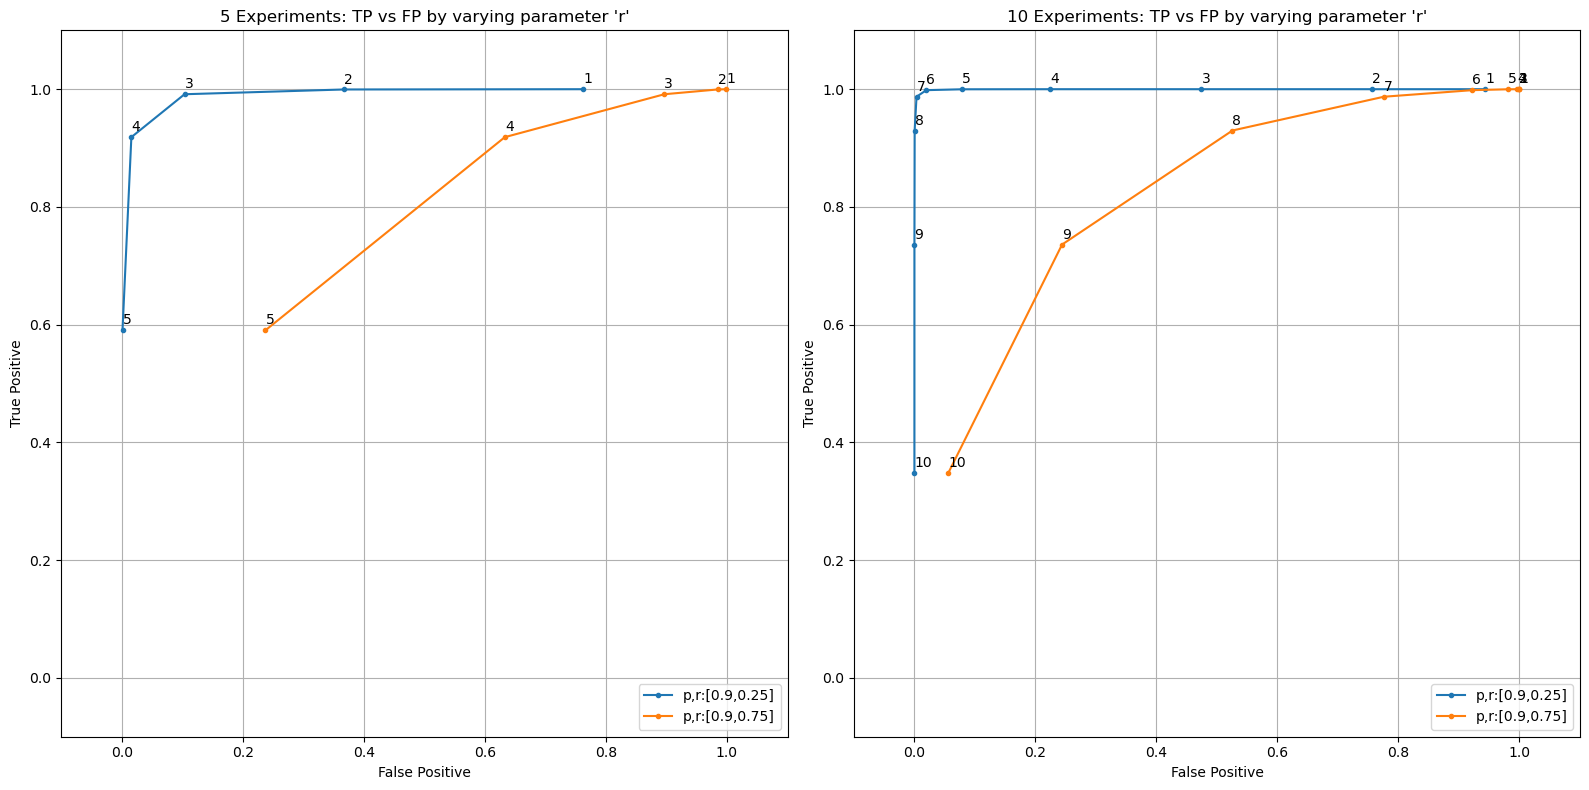

In [63]:
# r change
# threshold_num_runs = 2 # rule
min_exp_runs = 5
max_exp_runs = 10

total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))

p_list = [0.5,0.6,0.7,0.8,0.9]
p_list = [0.9]
p = p_list[0]
r_list = [0.25,0.75]
# r = 0.3

row = []



for total_exp_runs in total_exp_runs_list:
    
    for threshold_num_runs in range(1,total_exp_runs+1):
            # Printer.cyan(threshold_num_runs)
            # if total_exp_runs%3!=0:
            #     continue
            # else: pass
            # for p in p_list:
            for r in r_list:
            

                # print("p(successful run|algo = T):",p)
                # print("p(successful run|algo = F):",r)#," r = ",k,"*","p")
                exp_T = getBinomProb(total_exp_runs,p)
                exp_F = getBinomProb(total_exp_runs,r)
                exp_dict = {"True":exp_T,"False":exp_F}
                exp_cpt = pd.DataFrame(exp_dict)
                test_keys = []
                test_values = []

                for i in range(total_exp_runs+1):
                    test_keys.append(str(i))
                    if i >= threshold_num_runs:
                        test_values.append([1,0])
                    else:
                        test_values.append([0,1])

                test_results_dict = dict(zip(test_keys, test_values))
                test_results_cpt = pd.DataFrame(test_results_dict) 
                test_results_cpt["States"] = ['Correct','Incorrect']
                test_results_cpt.set_index("States",inplace=True)
                
                # display(test_results_cpt)


                # Create nodes by manually typing in probabilities
                test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                bbn = Bbn() \
                    .add_node(algo) \
                    .add_node(exp1) \
                    .add_node(test_results) \
                    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                join_tree = InferenceController.apply(bbn)

                dffp,dftn = getFPTN(join_tree)
                dffn,dftp = getFNTP(join_tree)
                
                # print("FP : P(Test=T|Algo=F)=",dffp.tolist())
                # print("TN : P(Test=F|Algo=F)=",dftn.tolist())
                # print("FN : P(Test=F|Algo=T)=",dffn.tolist())
                # print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                fp = dffp.tolist()[0]
                tn = dftn.tolist()[0]
                fn = dffn.tolist()[0]
                tp = dftp.tolist()[0]

                data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                row.append(data)
                
    checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
#     display(checkdf)
    
df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
# display(df)    

dfs = df.groupby(['n_exp','p','r'])   
fig = go.Figure()
best_dfs = []
subplots_df = []
for i in dfs:
    # display(i[1])
#     fig = go.Figure()
#     fig = px.line(i[1], x="fp", y="tp",text='threshold_exp',hover_data=['n_exp','threshold_exp','p','r'],color='n_exp',markers=True)
#     fig.update_traces(textposition='top center')
#     fig.update_layout(title_text="{Number of experiments vs Threshold Runs at (p,r):{"+str(p)+","+str(r)+"}")
#     fig.show()
    # print(i[1].columns)
    # calculate difference between max and min values
    fpr = i[1].fp.to_numpy()
    tpr = i[1].tp.to_numpy()
    distances = [np.sqrt((1 - tpr[i])**2 + fpr[i]**2) for i in range(len(fpr))]
    i[1]["distances"] = distances
    # find index of the point with minimum distance
    min_index = np.argmin(distances)
    # get the corresponding values of FP and TP
    best_fp = fpr[min_index]
    best_tp = tpr[min_index]
    # find the row with the least value in the 'Salary' column
    best = i[1].loc[i[1]['distances'].idxmin()].to_frame().transpose()
    best['n_exp'] = best['n_exp'].astype(int)
    best['threshold_exp'] = best['threshold_exp'].astype(int)
    best.columns = ["Number of Experiments","Threshold number of successes","p","r","FP","TN","FN","TP","distances"]
    
    p = i[1].p.unique().tolist()[0]
    r = i[1].r.unique().tolist()[0]
    subplots_df.append(i[1])
    # plt.plot(i[1].fp,i[1].tp,marker=".")
    # for j in range(len(i[1])):
    #     plt.annotate(str(i[1].threshold_exp.tolist()[j]), ((i[1].iloc[j].fp), (i[1].iloc[j].tp)+0.01))
    # plt.legend(["#Experiments: "+str(i[1].n_exp.unique().tolist()[0])]  ,loc='lower right')
    # plt.xlabel("False Positive")
    # plt.ylabel("True Positive")
    # plt.title(str(i[1].n_exp.unique().tolist()[0])+" experiments run at (p,r):{"+str(p)+","+str(r)+"}")
    # plt.xlim([-0.1,1.1])
    # plt.ylim([-0.1,1.1])
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
    # display(best)
    best_dfs.append(best)
    # Printer.green(f"TP closest to the perfect classifier: {best_tp:.3f}")
    # Printer.orange(f"FP closest to the perfect classifier: {best_fp:.3f}")
    
result = pd.concat(best_dfs, axis=0, ignore_index=True)
# drop a column
result = result.drop('distances', axis=1)
result = result.round({'TP':4,'TN':4,'FP':4,'FN':4})
# convert the 'float_col' column to integer

# display(result)
rvals = '-'.join(str(e) for e in result.r.unique().tolist())
pvals = '-'.join(str(e) for e in result.p.unique().tolist())
fname = '-'.join(['p',pvals,'r',rvals])+".csv"
# result.to_csv(fname, index=False)

# r changed
concatenated_df = pd.concat(subplots_df, axis=0)


display(concatenated_df[(concatenated_df.n_exp == 5)&(concatenated_df.threshold_exp == 3)])


n0 = min_exp_runs
r0 = r_list[0]
r1 = r_list[1]
str0 = "p,r:["+str(p_list[0])+","+str(r0)+"]"
str1 = "p,r:["+str(p_list[0])+","+str(r1)+"]"

plt.figure(figsize=(16,8))
plt.subplot(121)
for j in range(len(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)])):
    plt.annotate(str(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].threshold_exp.tolist()[j]), 
                     ((concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].iloc[j].fp), 
                      (concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].iloc[j].tp)+0.01))

for j in range(len(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r1)])):
    plt.annotate(str(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r1)].threshold_exp.tolist()[j]), 
                     ((concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r1)].iloc[j].fp), 
                      (concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r1)].iloc[j].tp)+0.01))
plt.plot(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].fp,concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].tp,marker=".")
plt.plot(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r1)].fp,concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r1)].tp,marker=".")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title(str(n0)+" Experiments: TP vs FP by varying parameter 'r'")
plt.legend([str0,str1],loc='lower right')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(True)


n0 = max_exp_runs
r0 = r_list[0]
r1 = r_list[1]

plt.subplot(122)
for j in range(len(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)])):
    plt.annotate(str(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].threshold_exp.tolist()[j]), 
                     ((concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].iloc[j].fp), 
                      (concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].iloc[j].tp)+0.01))

for j in range(len(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r1)])):
    plt.annotate(str(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r1)].threshold_exp.tolist()[j]), 
                     ((concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r1)].iloc[j].fp), 
                      (concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r1)].iloc[j].tp)+0.01))
plt.plot(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].fp,concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].tp,marker=".")
plt.plot(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r1)].fp,concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r1)].tp,marker=".")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title(str(n0)+" Experiments: TP vs FP by varying parameter 'r'")
plt.legend([str0,str1],loc='lower right')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(True)

fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig("trend_r_increase.png", dpi=300)

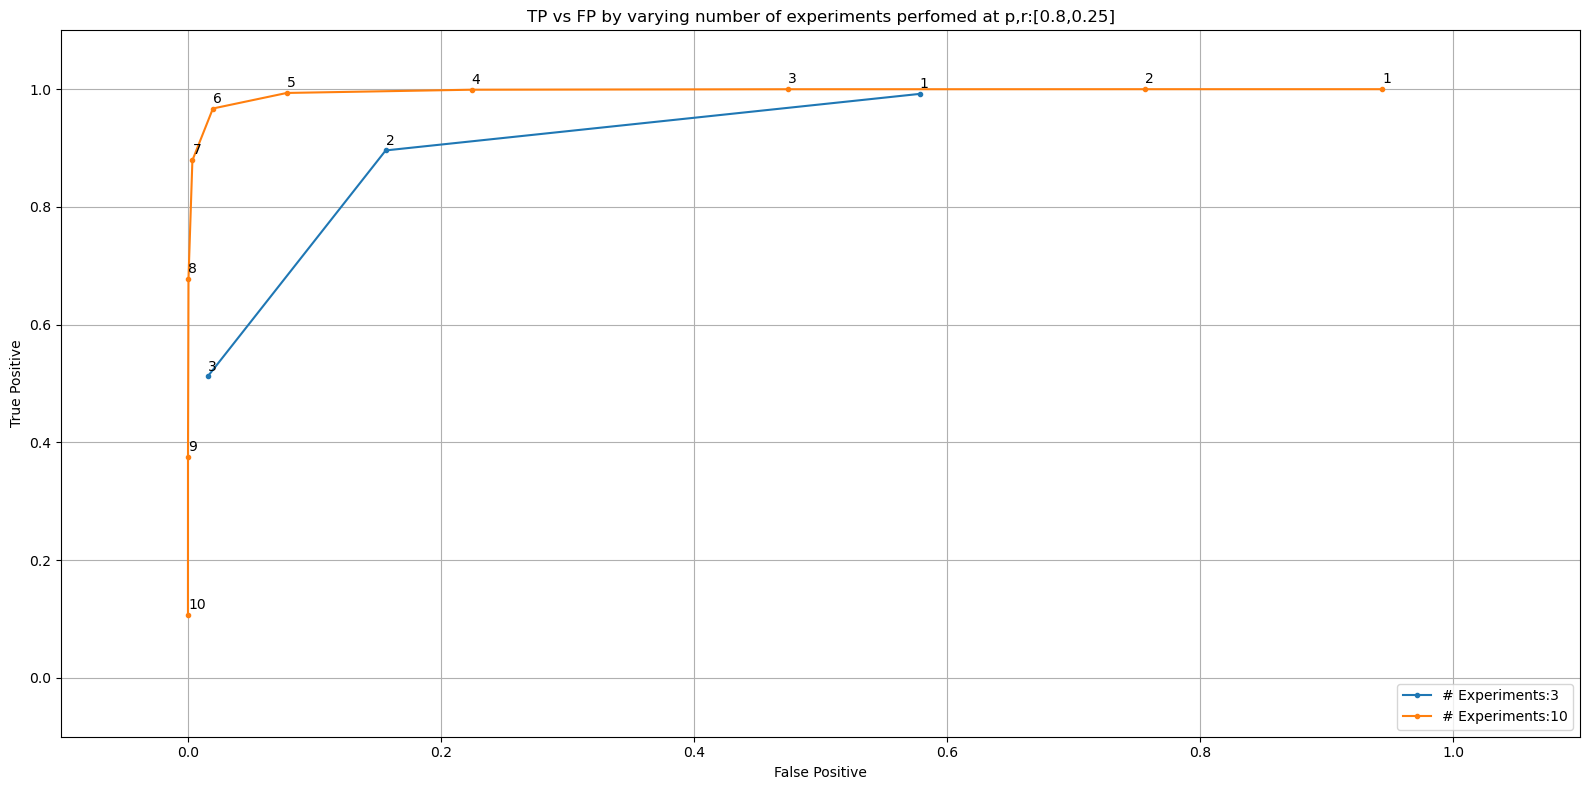

In [58]:
# only n_exp increases


# sns.set_theme()

# threshold_num_runs = 2 # rule
min_exp_runs = 3
max_exp_runs = 10

total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))

p_list = [0.5,0.6,0.7,0.8,0.9]
p_list = [0.8]
p = p_list[0]
r_list = [0.25]

row = []



for total_exp_runs in total_exp_runs_list:
    
    for threshold_num_runs in range(1,total_exp_runs+1):
            # Printer.cyan(threshold_num_runs)
            # if total_exp_runs%3!=0:
            #     continue
            # else: pass
            # for p in p_list:
            for r in r_list:
            

                # print("p(successful run|algo = T):",p)
                # print("p(successful run|algo = F):",r)#," r = ",k,"*","p")
                exp_T = getBinomProb(total_exp_runs,p)
                exp_F = getBinomProb(total_exp_runs,r)
                exp_dict = {"True":exp_T,"False":exp_F}
                exp_cpt = pd.DataFrame(exp_dict)
                test_keys = []
                test_values = []

                for i in range(total_exp_runs+1):
                    test_keys.append(str(i))
                    if i >= threshold_num_runs:
                        test_values.append([1,0])
                    else:
                        test_values.append([0,1])

                test_results_dict = dict(zip(test_keys, test_values))
                test_results_cpt = pd.DataFrame(test_results_dict) 
                test_results_cpt["States"] = ['Correct','Incorrect']
                test_results_cpt.set_index("States",inplace=True)
                
                # display(test_results_cpt)


                # Create nodes by manually typing in probabilities
                test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                bbn = Bbn() \
                    .add_node(algo) \
                    .add_node(exp1) \
                    .add_node(test_results) \
                    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                join_tree = InferenceController.apply(bbn)

                dffp,dftn = getFPTN(join_tree)
                dffn,dftp = getFNTP(join_tree)
                
                # print("FP : P(Test=T|Algo=F)=",dffp.tolist())
                # print("TN : P(Test=F|Algo=F)=",dftn.tolist())
                # print("FN : P(Test=F|Algo=T)=",dffn.tolist())
                # print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                fp = dffp.tolist()[0]
                tn = dftn.tolist()[0]
                fn = dffn.tolist()[0]
                tp = dftp.tolist()[0]

                data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                row.append(data)
                
    checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
#     display(checkdf)
    
df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
# display(df)    

dfs = df.groupby(['n_exp','p','r'])   
fig = go.Figure()
best_dfs = []
subplots_df = []
for i in dfs:
    # display(i[1])
#     fig = go.Figure()
#     fig = px.line(i[1], x="fp", y="tp",text='threshold_exp',hover_data=['n_exp','threshold_exp','p','r'],color='n_exp',markers=True)
#     fig.update_traces(textposition='top center')
#     fig.update_layout(title_text="{Number of experiments vs Threshold Runs at (p,r):{"+str(p)+","+str(r)+"}")
#     fig.show()
    # print(i[1].columns)
    # calculate difference between max and min values
    fpr = i[1].fp.to_numpy()
    tpr = i[1].tp.to_numpy()
    distances = [np.sqrt((1 - tpr[i])**2 + fpr[i]**2) for i in range(len(fpr))]
    i[1]["distances"] = distances
    # find index of the point with minimum distance
    min_index = np.argmin(distances)
    # get the corresponding values of FP and TP
    best_fp = fpr[min_index]
    best_tp = tpr[min_index]
    # find the row with the least value in the 'Salary' column
    best = i[1].loc[i[1]['distances'].idxmin()].to_frame().transpose()
    best['n_exp'] = best['n_exp'].astype(int)
    best['threshold_exp'] = best['threshold_exp'].astype(int)
    best.columns = ["Number of Experiments","Threshold number of successes","p","r","FP","TN","FN","TP","distances"]
    
    p = i[1].p.unique().tolist()[0]
    r = i[1].r.unique().tolist()[0]
    subplots_df.append(i[1])
    # plt.plot(i[1].fp,i[1].tp,marker=".")
    # for j in range(len(i[1])):
    #     plt.annotate(str(i[1].threshold_exp.tolist()[j]), ((i[1].iloc[j].fp), (i[1].iloc[j].tp)+0.01))
    # plt.legend(["#Experiments: "+str(i[1].n_exp.unique().tolist()[0])]  ,loc='lower right')
    # plt.xlabel("False Positive")
    # plt.ylabel("True Positive")
    # plt.title(str(i[1].n_exp.unique().tolist()[0])+" experiments run at (p,r):{"+str(p)+","+str(r)+"}")
    # plt.xlim([-0.1,1.1])
    # plt.ylim([-0.1,1.1])
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
    # display(best)
    best_dfs.append(best)
    # Printer.green(f"TP closest to the perfect classifier: {best_tp:.3f}")
    # Printer.orange(f"FP closest to the perfect classifier: {best_fp:.3f}")
    
result = pd.concat(best_dfs, axis=0, ignore_index=True)
# drop a column
result = result.drop('distances', axis=1)
result = result.round({'TP':4,'TN':4,'FP':4,'FN':4})
# convert the 'float_col' column to integer

# display(result)
rvals = '-'.join(str(e) for e in result.r.unique().tolist())
pvals = '-'.join(str(e) for e in result.p.unique().tolist())
fname = '-'.join(['p',pvals,'r',rvals])+".csv"
# result.to_csv(fname, index=False)

# r changed
concatenated_df = pd.concat(subplots_df, axis=0)


n0 = min_exp_runs

plt.figure(figsize=(16,8))
leg = []

# int((min_exp_runs+max_exp_runs)/2)

for n0 in [min_exp_runs,max_exp_runs]:
    
    leg0 = "# Experiments:"+str(n0)
    leg.append(leg0)
    p0 = p_list[0]
    r0 = r_list[0]
    str0 = "p,r:["+str(p_list[0])+","+str(r0)+"]"


    
    for j in range(len(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)])):
        plt.annotate(str(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].threshold_exp.tolist()[j]), 
                        ((concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].iloc[j].fp), 
                        (concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].iloc[j].tp)+0.01))
        ci = ci+1
    plt.plot(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].fp,concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].tp,marker=".")


plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("TP vs FP by varying number of experiments perfomed at p,r:["+str(p_list[0])+","+str(r_list[0])+"]")
plt.legend(leg,loc='lower right')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(True)

fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig("trend_exp_increase=["+str(p_list[0])+","+str(r_list[0])+"].png", dpi=300)

,n_exp,threshold_exp,p,r,fp,tn,fn,tp
0,3,0,0.6,0.5,1.000000,0.000000,0.000000,1.000000
1,3,1,0.6,0.5,0.875000,0.125000,0.064000,0.936000
2,3,2,0.6,0.5,0.500000,0.500000,0.352000,0.648000
3,3,3,0.6,0.5,0.125000,0.875000,0.784000,0.216000
4,4,0,0.6,0.5,1.000000,0.000000,0.000000,1.000000
5,4,1,0.6,0.5,0.937500,0.062500,0.025600,0.974400
6,4,2,0.6,0.5,0.687500,0.312500,0.179200,0.820800
7,4,3,0.6,0.5,0.312500,0.687500,0.524800,0.475200
8,4,4,0.6,0.5,0.062500,0.937500,0.870400,0.129600
9,5,0,0.6,0.5,1.000000,0.000000,0.000000,1.000000


,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP
0,3,2,0.6,0.5,0.5000,0.5000,0.3520,0.6480
1,4,3,0.6,0.5,0.3125,0.6875,0.5248,0.4752
2,5,3,0.6,0.5,0.5000,0.5000,0.3174,0.6826
3,6,4,0.6,0.5,0.3438,0.6562,0.4557,0.5443
4,7,4,0.6,0.5,0.5000,0.5000,0.2898,0.7102
5,8,5,0.6,0.5,0.3633,0.6367,0.4059,0.5941
6,9,5,0.6,0.5,0.5000,0.5000,0.2666,0.7334
7,10,6,0.6,0.5,0.3770,0.6230,0.3669,0.6331


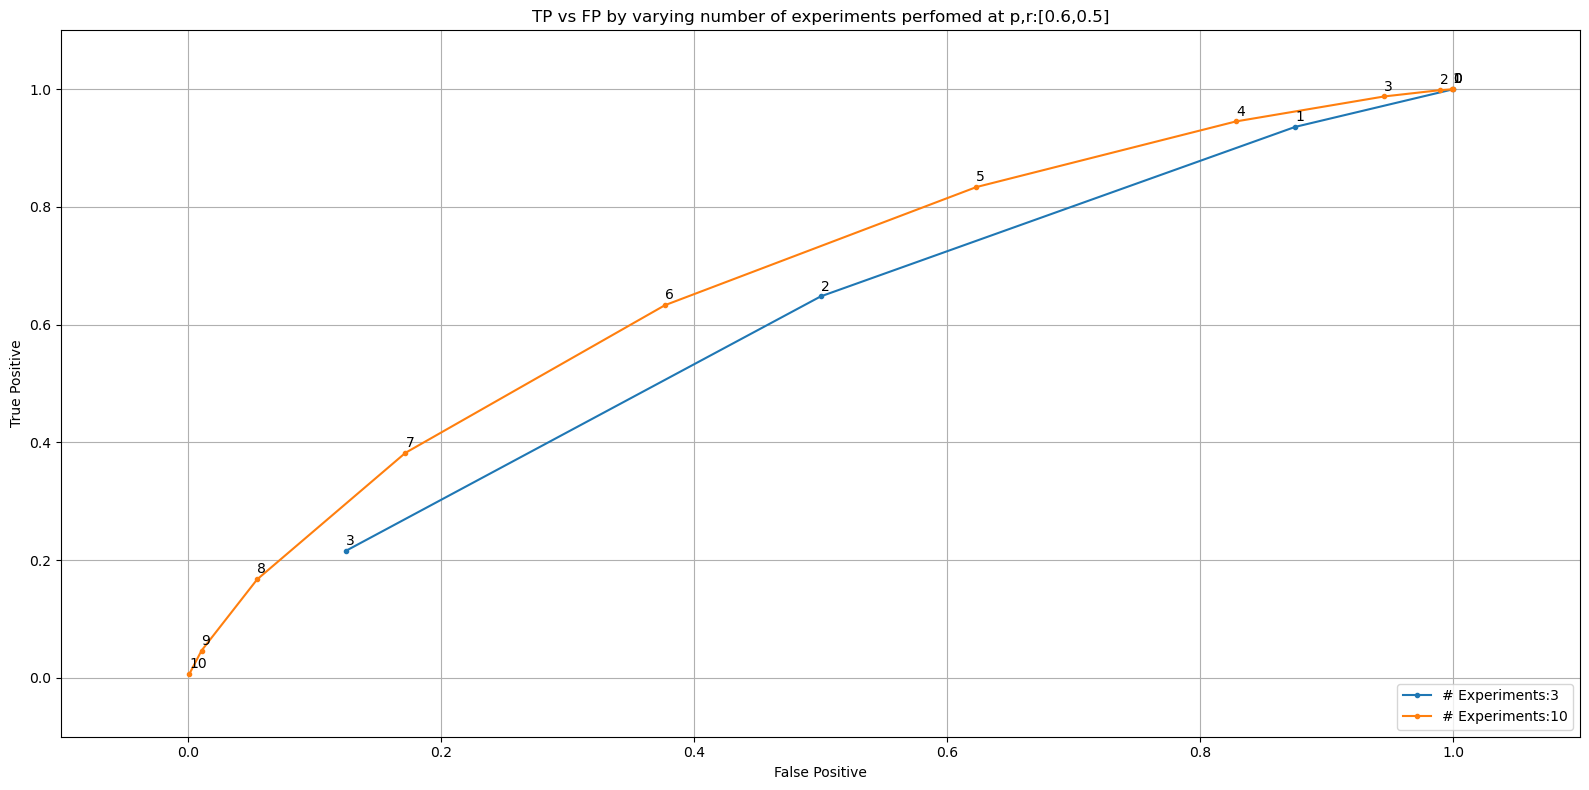

In [59]:
# only n_exp increases


# sns.set_theme()

# threshold_num_runs = 2 # rule
min_exp_runs = 3
max_exp_runs = 10

total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))

p_list = [0.5,0.6,0.7,0.8,0.9]
p_list = [0.6]
p = p_list[0]
r_list = [0.5]

row = []



for total_exp_runs in total_exp_runs_list:
    
    for threshold_num_runs in range(0,total_exp_runs+1):
            # Printer.cyan(threshold_num_runs)
            # if total_exp_runs%3!=0:
            #     continue
            # else: pass
            # for p in p_list:
            for r in r_list:
            

                # print("p(successful run|algo = T):",p)
                # print("p(successful run|algo = F):",r)#," r = ",k,"*","p")
                exp_T = getBinomProb(total_exp_runs,p)
                exp_F = getBinomProb(total_exp_runs,r)
                exp_dict = {"True":exp_T,"False":exp_F}
                exp_cpt = pd.DataFrame(exp_dict)
                test_keys = []
                test_values = []

                for i in range(total_exp_runs+1):
                    test_keys.append(str(i))
                    if i >= threshold_num_runs:
                        test_values.append([1,0])
                    else:
                        test_values.append([0,1])

                test_results_dict = dict(zip(test_keys, test_values))
                test_results_cpt = pd.DataFrame(test_results_dict) 
                test_results_cpt["States"] = ['Correct','Incorrect']
                test_results_cpt.set_index("States",inplace=True)
                
                # display(test_results_cpt)


                # Create nodes by manually typing in probabilities
                test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                bbn = Bbn() \
                    .add_node(algo) \
                    .add_node(exp1) \
                    .add_node(test_results) \
                    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                join_tree = InferenceController.apply(bbn)

                dffp,dftn = getFPTN(join_tree)
                dffn,dftp = getFNTP(join_tree)
                
                # print("FP : P(Test=T|Algo=F)=",dffp.tolist())
                # print("TN : P(Test=F|Algo=F)=",dftn.tolist())
                # print("FN : P(Test=F|Algo=T)=",dffn.tolist())
                # print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                fp = dffp.tolist()[0]
                tn = dftn.tolist()[0]
                fn = dffn.tolist()[0]
                tp = dftp.tolist()[0]

                data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                row.append(data)
                
    checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
#     display(checkdf)
    
df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
display(df)    

dfs = df.groupby(['n_exp','p','r'])   
fig = go.Figure()
best_dfs = []
subplots_df = []
for i in dfs:
    # display(i[1])
#     fig = go.Figure()
#     fig = px.line(i[1], x="fp", y="tp",text='threshold_exp',hover_data=['n_exp','threshold_exp','p','r'],color='n_exp',markers=True)
#     fig.update_traces(textposition='top center')
#     fig.update_layout(title_text="{Number of experiments vs Threshold Runs at (p,r):{"+str(p)+","+str(r)+"}")
#     fig.show()
    # print(i[1].columns)
    # calculate difference between max and min values
    fpr = i[1].fp.to_numpy()
    tpr = i[1].tp.to_numpy()
    distances = [np.sqrt((1 - tpr[i])**2 + fpr[i]**2) for i in range(len(fpr))]
    i[1]["distances"] = distances
    # find index of the point with minimum distance
    min_index = np.argmin(distances)
    # get the corresponding values of FP and TP
    best_fp = fpr[min_index]
    best_tp = tpr[min_index]
    # find the row with the least value in the 'Salary' column
    best = i[1].loc[i[1]['distances'].idxmin()].to_frame().transpose()
    best['n_exp'] = best['n_exp'].astype(int)
    best['threshold_exp'] = best['threshold_exp'].astype(int)
    best.columns = ["Number of Experiments","Threshold number of successes","p","r","FP","TN","FN","TP","distances"]
    
    p = i[1].p.unique().tolist()[0]
    r = i[1].r.unique().tolist()[0]
    subplots_df.append(i[1])
    # plt.plot(i[1].fp,i[1].tp,marker=".")
    # for j in range(len(i[1])):
    #     plt.annotate(str(i[1].threshold_exp.tolist()[j]), ((i[1].iloc[j].fp), (i[1].iloc[j].tp)+0.01))
    # plt.legend(["#Experiments: "+str(i[1].n_exp.unique().tolist()[0])]  ,loc='lower right')
    # plt.xlabel("False Positive")
    # plt.ylabel("True Positive")
    # plt.title(str(i[1].n_exp.unique().tolist()[0])+" experiments run at (p,r):{"+str(p)+","+str(r)+"}")
    # plt.xlim([-0.1,1.1])
    # plt.ylim([-0.1,1.1])
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
    # display(best)
    best_dfs.append(best)
    # Printer.green(f"TP closest to the perfect classifier: {best_tp:.3f}")
    # Printer.orange(f"FP closest to the perfect classifier: {best_fp:.3f}")
    
result = pd.concat(best_dfs, axis=0, ignore_index=True)
# drop a column
result = result.drop('distances', axis=1)
result = result.round({'TP':4,'TN':4,'FP':4,'FN':4})
# convert the 'float_col' column to integer

display(result)
rvals = '-'.join(str(e) for e in result.r.unique().tolist())
pvals = '-'.join(str(e) for e in result.p.unique().tolist())
fname = '-'.join(['p',pvals,'r',rvals])+".csv"
# result.to_csv(fname, index=False)

# r changed
concatenated_df = pd.concat(subplots_df, axis=0)


n0 = min_exp_runs

plt.figure(figsize=(16,8))
leg = []

# int((min_exp_runs+max_exp_runs)/2)

for n0 in [min_exp_runs,max_exp_runs]:
    
    leg0 = "# Experiments:"+str(n0)
    leg.append(leg0)
    p0 = p_list[0]
    r0 = r_list[0]
    str0 = "p,r:["+str(p_list[0])+","+str(r0)+"]"


    
    for j in range(len(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)])):
        plt.annotate(str(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].threshold_exp.tolist()[j]), 
                        ((concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].iloc[j].fp), 
                        (concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].iloc[j].tp)+0.01))
        ci = ci+1
    plt.plot(concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].fp,concatenated_df[(concatenated_df.n_exp == n0) & (concatenated_df.r == r0)].tp,marker=".")


plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("TP vs FP by varying number of experiments perfomed at p,r:["+str(p_list[0])+","+str(r_list[0])+"]")
plt.legend(leg,loc='lower right')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(True)

fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig("trend_exp_increase=["+str(p_list[0])+","+str(r_list[0])+"].png", dpi=300)

/var/folders/fl/s4bc006j105fpvzv3f3tbnyw0000gn/T/ipykernel_73277/3997185135.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




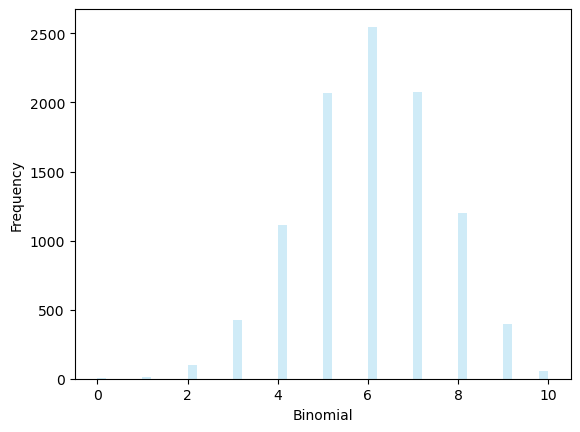

/var/folders/fl/s4bc006j105fpvzv3f3tbnyw0000gn/T/ipykernel_73277/3997185135.py:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




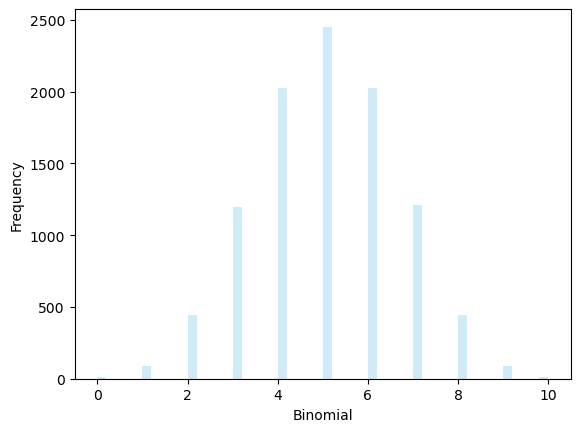

In [53]:
data_binom = binom.rvs(n=max_exp_runs,p=p_list[0],size=10000)
ax = sns.distplot(data_binom,
                  kde=False,
                  color='skyblue')
ax.set(xlabel='Binomial', ylabel='Frequency')
plt.show()

data_binom = binom.rvs(n=max_exp_runs,p=r_list[0],size=10000)
ax = sns.distplot(data_binom,
                  kde=False,
                  color='skyblue')
ax.set(xlabel='Binomial', ylabel='Frequency')
plt.show()